# MRS point source spectral extraction
The method to extract a 1D spectrum from a detector slope image is illustrated in this notebook for the case of a point source observation. Two methods are shown, one is aperture photometry, and the other is PSF-weighted (optimal) spectral extraction.  
  
The notebook was created on: November 3rd 2017  
The author of the notebook is: Ioannis Argyriou (Institute of Astronomy, KUL)  
The author's email is: ioannis.argyriou@kuleuven.be

## So let's start! First import all the required python modules

In [1]:
from distortionMaps import d2cMapping
import funcs

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

## Second, load the filenames and the data therein to-be used in this notebook

In [2]:
# 1-Define the paths to the data
workDir = '/Users/ioannisa/Desktop/python/miri_devel/'
dataDir = workDir+'CV2_data/LVL2/'
cdpDir  = workDir+'cdp_data/'

# 2-Get the data: in this case we are examining a point source observation taken from the CV3 data, in band 1A/2A, in the form of slope images (LVL2 data)
science_img_file    = dataDir+'MIRM0363-P13-SHORT-4230052018_1_495_SE_2014-08-18T05h39m05_LVL2.fits'
background_img_file = dataDir+'MIRM0363-P13-SHRTB-4230051313_1_495_SE_2014-08-18T05h39m25_LVL2.fits'

source_signal,background_signal = fits.open(science_img_file)[0].data[0,:,:],fits.open(background_img_file)[0].data[0,:,:]
source_signal_error,background_signal_error = fits.open(science_img_file)[0].data[1,:,:],fits.open(background_img_file)[0].data[1,:,:]

# 3-load the MRS distortion maps, they are used extensively in a multitude of python functions relating to the analysis of MRS data
band     = '1A' # this is the spectral band (side of the slope image) to be analyzed
d2cMaps  = d2cMapping(band,cdpDir) # here, d2c stands for detector to cube transformation, from x,y integer pixel coordinates, to alpha, beta (or RA and DEC), and wavelength coordinates
det_dims = (1024,1032) # placeholder for the dimension of the detector

# 4-load the calibration data products (cdps) applicable to the spectral band specified above; these products are used for the calibration of the slope images, from LVL2 to so-called "LVL3" data
fringe_file,photom_file,psf_file,resol_file = funcs.get_cdps(cdpDir=cdpDir,band=band)

fringe_img,fringe_err = fits.open(fringe_file)[1].data,fits.open(fringe_file)[2].data # [unitless]
photom_img,photom_err = fits.open(photom_file)[1].data,fits.open(fringe_file)[2].data # [DN/s * pixel/mJy]
pixsiz_img    = fits.open(photom_file)[5].data  # [arcsec^2/pix]
psffits       = fits.open(psf_file)             # [unitless]
specres_table = fits.open(resol_file)[1].data   # [unitless]

## Now that we have all the input data for the analysis, we transform said data to suit our needs  
What we basically do here is transform the MRS LVL2 slope image to a LVL3 (calibrated) image. This "pipeline" if you will, takes in pixel slopes, measured in DN/sec, and yields surface brightness, in units of mJy/arcsec^2, for every pixel on the detector.

In [3]:
# Starting from the top, we have:
# 1-background subtraction
source_signal_subtrbkg        = source_signal-background_signal                              # [DN/s/pix_{ij}]
source_signal_error_subtrbkg  = np.sqrt(source_signal_error**2 + background_signal_error**2) # [DN/s/pix_{ij}]

# 2-division by the fringe flat (note that an effective flat field calibration for the MRS is not available, thus it is omitted here)
source_signal_divfringe = source_signal_subtrbkg/fringe_img # [DN/s/pix_{ij}] 
source_signal_error_divfringe = np.abs(source_signal_divfringe)*np.sqrt( (source_signal_error_subtrbkg/source_signal_subtrbkg)**2 + (fringe_err/fringe_img)**2) # [DN/s/pix_{ij}]

# 3-division by the MRS spectral response function (contained in the "photom" cdp)
source_signal_divphotom = source_signal_divfringe/photom_img # [mJy/pix] (note here that the ij subscript has disappeared as the flat field division has changed the normalization to an average pixel area and responsivity)
source_signal_error_divphotom = np.abs(source_signal_divphotom)*np.sqrt( (source_signal_error_divfringe/source_signal_divfringe)**2 + (photom_err/photom_img)**2) # [mJy/pix]

# 4-division by the pixel spatial sizes (in units of arcsec^2/pix)
source_signal_divpixsiz = source_signal_divphotom/pixsiz_img # [mJy/arcsec^2]
source_signal_error_divpixsiz = source_signal_error_divphotom/pixsiz_img # [mJy/arcsec^2]

## Now we have pixels with units of surface brightness; let's extract a spectrum!  
Since we are dealing with a point source, we should know where the source's centroid is located. The reason for this is that we want to extract the signal from the source, rather than the background. This source centroid can be determined in different spectral bins on the detector ("at every lambda"), where the spectral width of a bin is proportional to the spectral resolution of the MRS.

In [4]:
# Let's construct this spectral grid, I have a nifty function that does that for me; the output is one central wavelength and one fwhm in spectral direction, for every cell in the grid
lambcens,lambfwhms = funcs.spectral_gridding(band=band,d2cMaps=d2cMaps,specres_table=specres_table)

In [5]:
# Having constructed the spectral grid, we now determine the centroid of the observed point source in every cell of the grid, or "bin" as I like to call it.
# There are three steps to the centroiding process:
# step 1: the detector slice with the largest contained flux is found, this gives a rough idea of the source spatial position, since every slice has a specific location in the MRS field of view (FOV)
# step 2: a 1D gaussian fitting is performed to the signal contained in the slice found in step 1; this effectively yields the spatial position of the peak in the MRS PSF
# step 3: a 2D gaussian fitting is performed to the signal contained in one spectral bin, covering all slices on the detector (you could imaginable do a PSF fitting here)
# the final output is the peak signal of the source, its spatial location in the FOV, and the standard deviations in the two respective FOV directions
sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta = funcs.point_source_centroiding(band=band,sci_img=source_signal_divpixsiz,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms])

STEP 1: Rough centroiding
Slice 18 has the largest summed flux
Source position: beta = 1.24arcsec, alpha = -1.48arcsec 

STEP 2: 1D Gaussian fit
[Along-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 590, 591, 592, 593, 594, 595, 596, 597, 598]
[Across-slice fit] The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]

STEP 3: 2D Gaussian fit
The following bins failed to converge:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 39, 40, 41, 43, 121, 122, 123, 197, 203, 295, 296, 304, 305, 306, 345, 346, 347, 348, 371, 372, 373, 374, 580, 581, 582, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598]


In [6]:
# Given that we now know the location of the point source, we can finally extract the signal from the detector in an optimized way
# One such way is to take a spatial aperture and extract all the signal from the pixels inside of said aperture.
# The aperture center in the two FOV directions is taken as the mean from our previous estimations in all the spectral bins. Note that the point source should not move in the spectral direction!
source_alpha_center = np.mean(alpha_centers[~np.isnan(alpha_centers)])
source_beta_center  = np.mean(beta_centers[~np.isnan(beta_centers)])

# The center of the source, is the center of the aperture that we will be using. Here I have implemented a function for an elliptical aperture, though using an axis ratio q=1 basically yields a circular aperture.
# The following function, yields all the pixels on the detector that "fall" within the elliptical/circular aperture. Additionally, the theoretical aperture area is computed.
pix_in_aperture,aperture_area = funcs.elliptical_aperture(center=[source_alpha_center,source_beta_center],r=0.5,q=1.,pa=0.,d2cMaps=d2cMaps)

# Since we now know which pixels fall inside our aperture, we can use this information to define an aperture mask that will subsequently be used to extract photometry from the un-masked pixels.
apertureMask = np.zeros(det_dims)
apertureMask[pix_in_aperture] = 1.

# Using all the intel we have accumulated up to this point, (at long last) we can extract flux from the detector pixels, to yield a 1D spectrum of the observed source
aperture_extracted_signal = funcs.aperture_photometry(band=band,sci_img=source_signal_divpixsiz,apertureMask=apertureMask,aperture_area=aperture_area,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms])
aperture_extracted_signal_error = np.sqrt(funcs.aperture_photometry(band=band,sci_img=source_signal_error_divpixsiz,apertureMask=apertureMask,aperture_area=aperture_area,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms],img_type='err'))

# I will show you a plot in a bit, but before that let us introduce an aperture correction, based on the fraction of the PSF that is left outside the aperture
# Since the MRS PSF is normalized (has unit flux), the fraction of the PSF that is left outside the aperture is equal to the inverse of the fraction that is inside the aperture
psf = funcs.evaluate_psf_cdp(psffits=psffits,source_center=[source_alpha_center,source_beta_center],d2cMaps=d2cMaps)
psf_extracted_signal = funcs.aperture_photometry(band=band,sci_img=psf,apertureMask=apertureMask,aperture_area=aperture_area,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms],img_type='psf')

# The aperture correction is introduced as a division below
aperture_extracted_signal_apercorr = aperture_extracted_signal/psf_extracted_signal

In [7]:
# Aperture photometry is of course one way to extract a 1D spectrum from a source; another way however is to perform PSF-weighted (optimal) spectral extraction.
# As the name of the technique implies, the PSF is used as a weight function in the process of adding up flux from different pixels. Note that in this case no aperture is defined, and all pixels are used in the calculation.
# This approach additionally takes into account the variance in the signal value of each pixel. This information is added to the weight function, yielding a spectrum with minimal pixel noise contribution (hence the term "optimal" extraction)
opspec_signal,opspec_signal_error = funcs.optimal_extraction(band=band,sci_img=source_signal_divpixsiz,err_img=source_signal_error_divpixsiz,psf=psf,spec_grid=[lambcens,lambfwhms],d2cMaps=d2cMaps)

## Let me show some plots illustrating the different parts of the analysis contained in this notebook

<IPython.core.display.Javascript object>


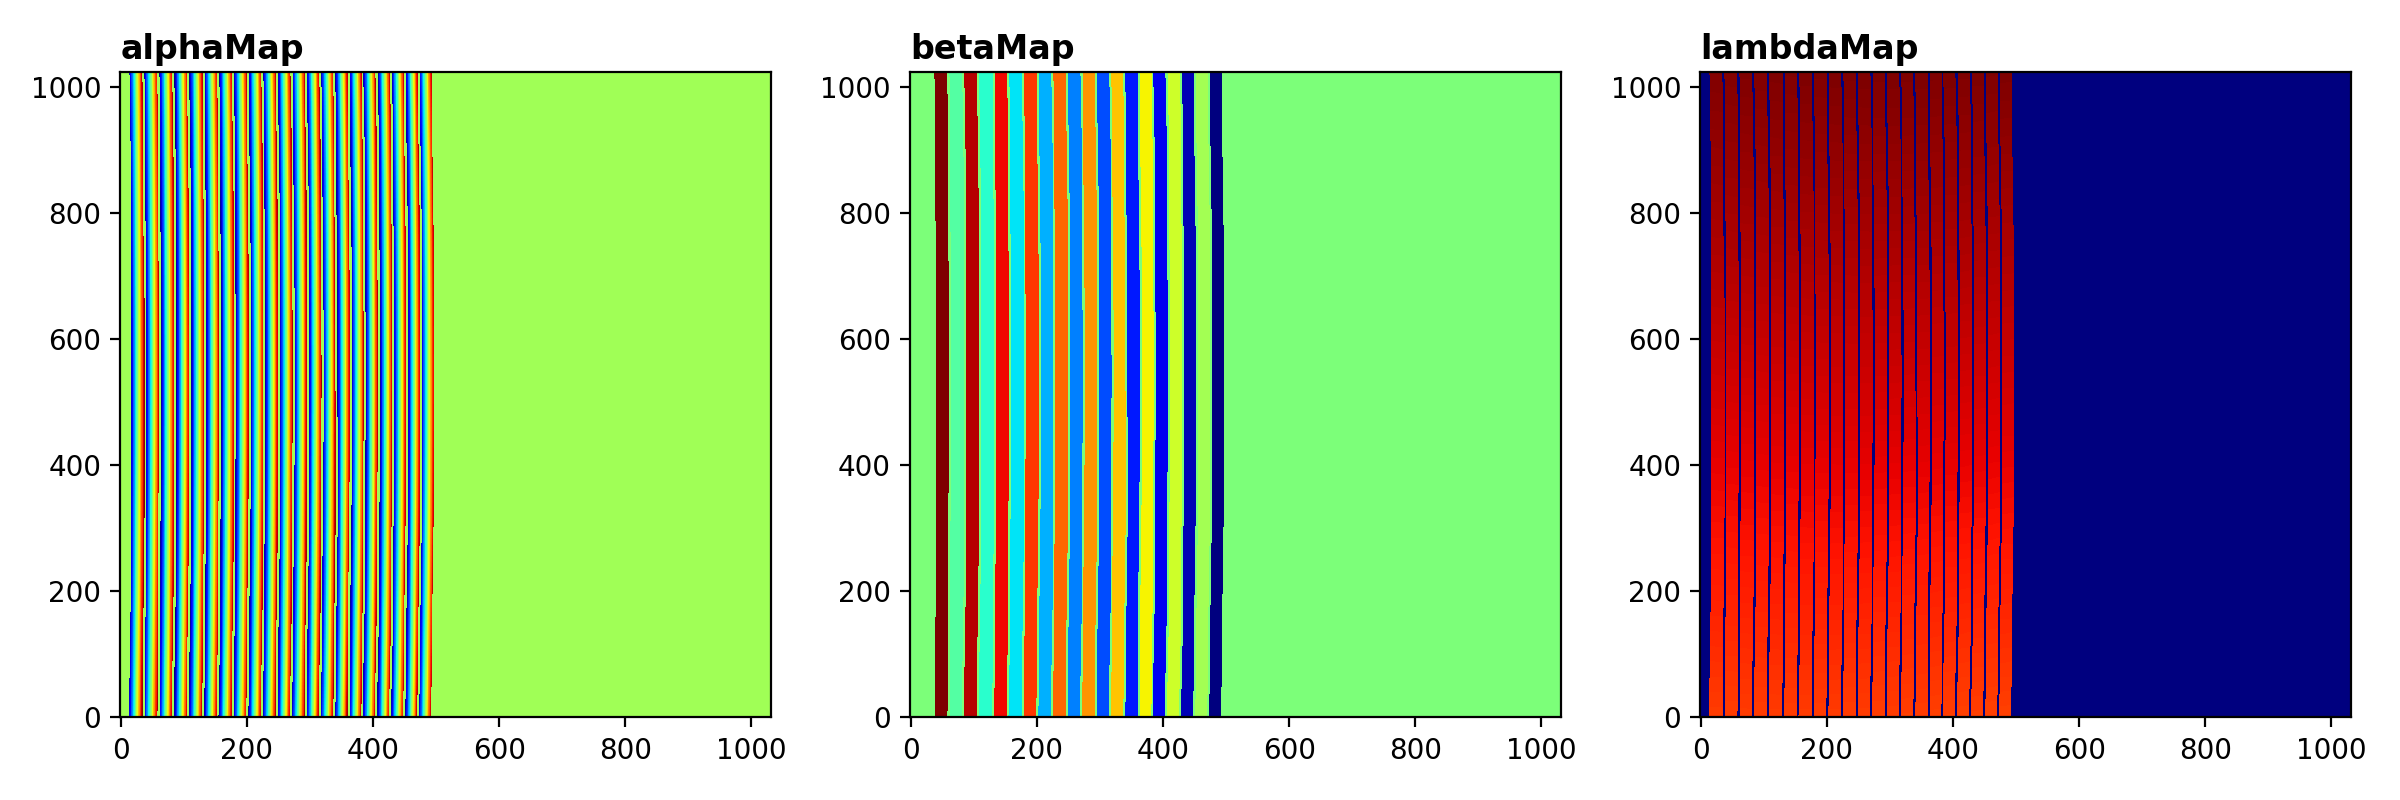

<IPython.core.display.Javascript object>


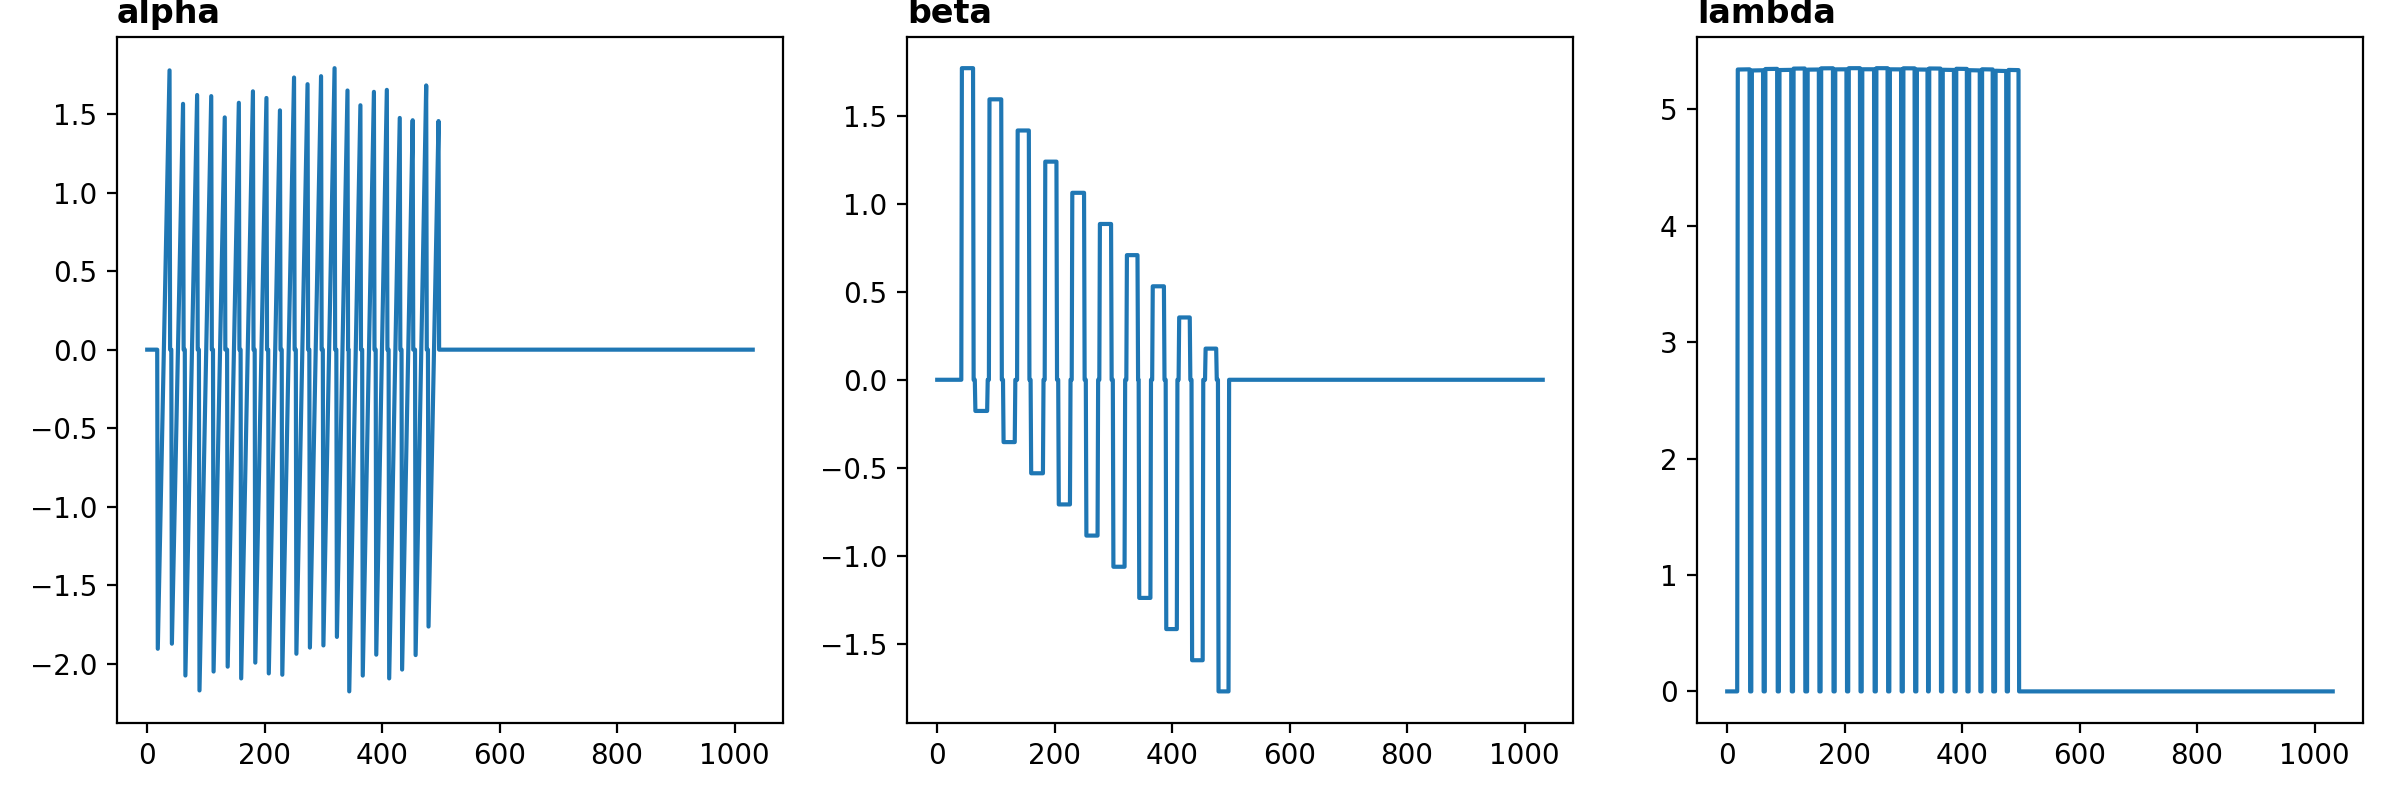

<IPython.core.display.Javascript object>


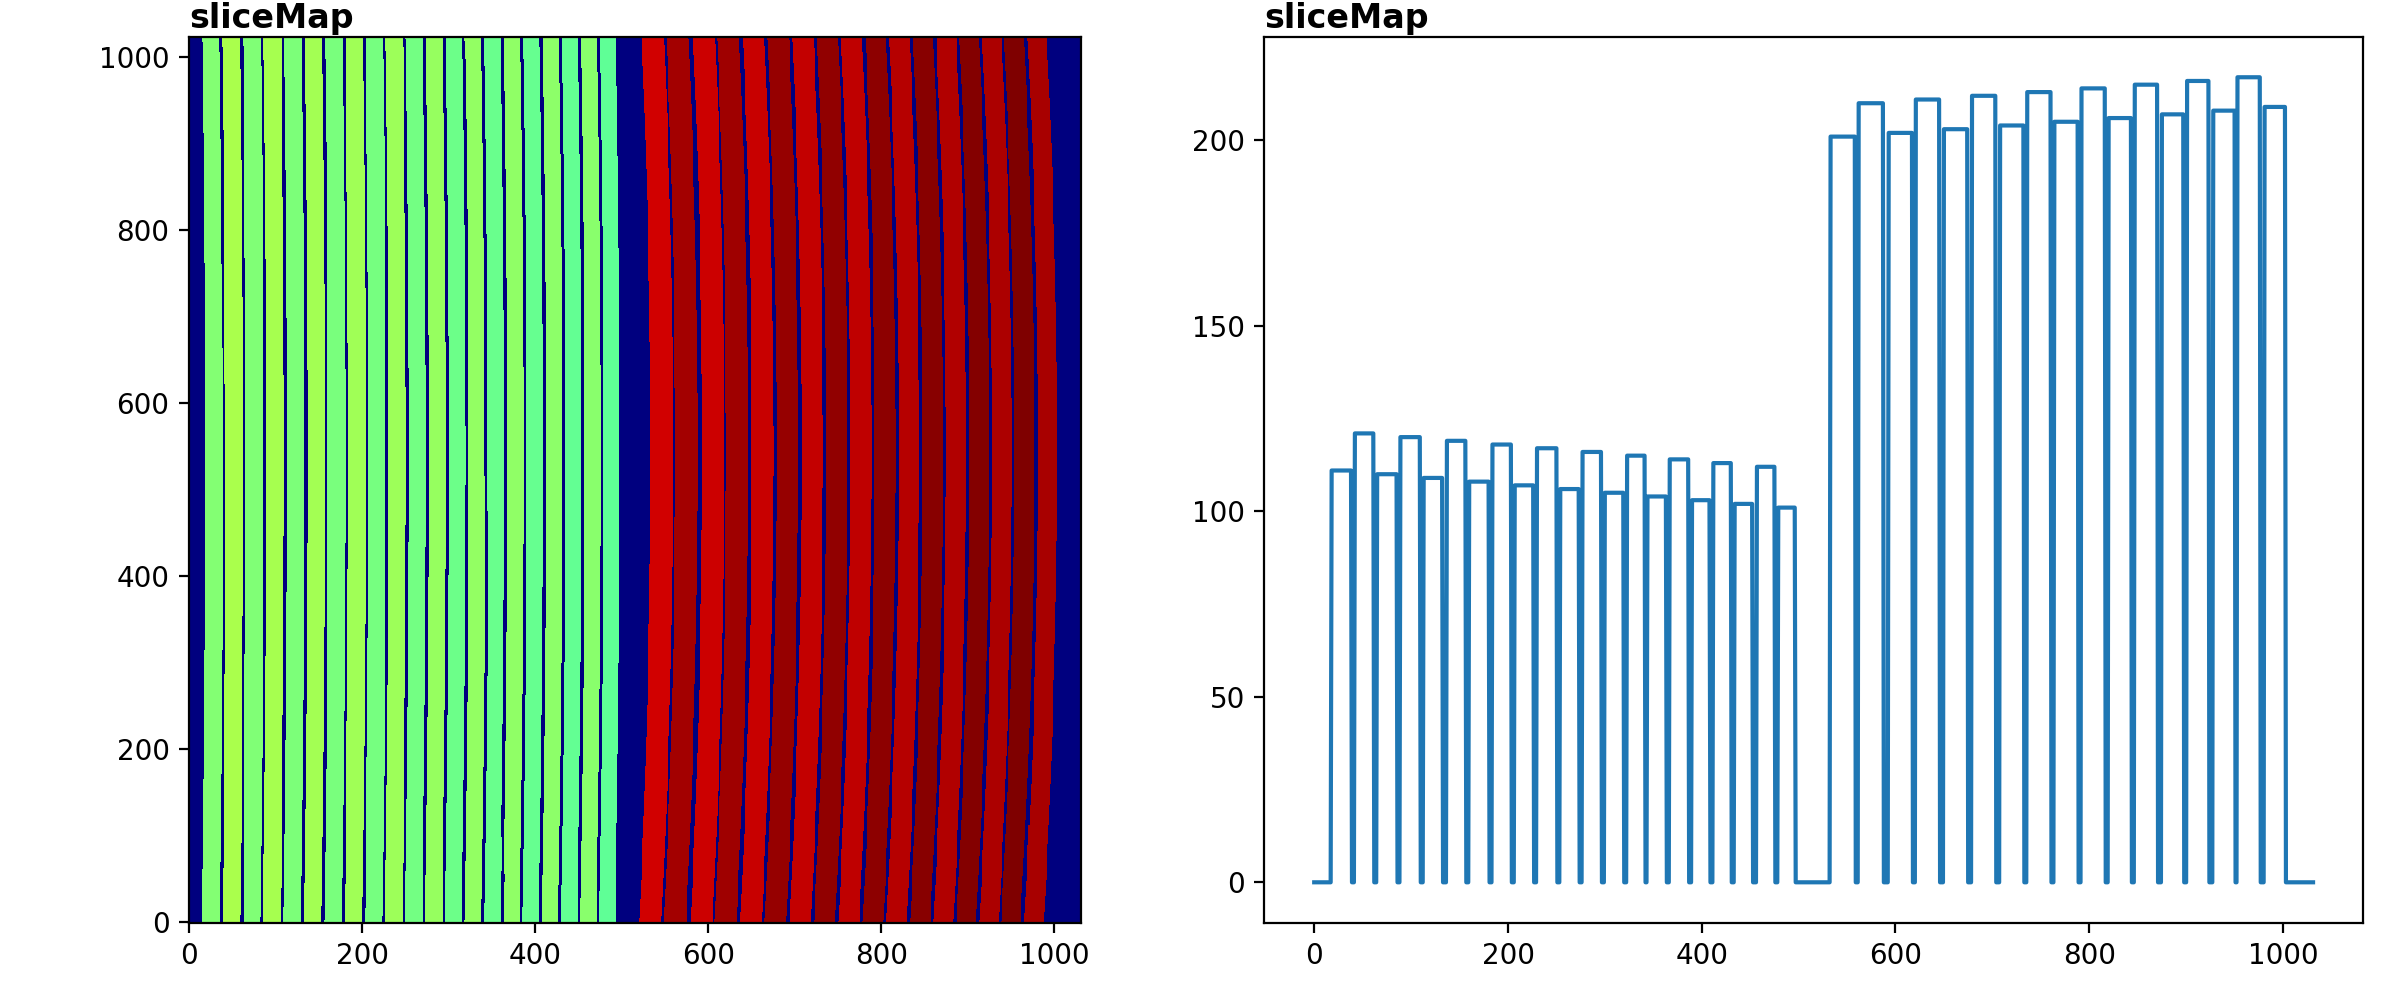

In [8]:
# First the reference distortion maps. These are the 3D spatial-and-spectral coordinates of the MRS integral field unit (IFU), projected on the detector 2D plane.
# Note that as a result of the 3D to 2D projection, every pixel has three coordinates! (a bit confusing I know, but that is how slicer IFUs work)
fig,axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(d2cMaps['alphaMap'],cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('alphaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(d2cMaps['betaMap'],cmap='jet', interpolation='nearest', origin='lower')
axs[1].annotate('betaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(d2cMaps['lambdaMap'],cmap='jet', interpolation='nearest', origin='lower')
axs[2].annotate('lambdaMap', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

# Taking a horizontal cut through the detector will perhaps yield more insight on how the cube coordinates vary in pixel space.
# As a quick summary, every slice corresponds to a single beta coordinates (and vice-versa), alpha changes (more or less) linearly in the horizontal direction of a slice,
# and finally the wavelength is (more or less) constant in the horizontal direction of a slice. The wavelength (dispersion) direction actually follows the vertical axis.
# Note though that when I mentioned "more or less" for the alpha and lambda coordinates' linearity, that is because this is not exactly true. 
# Because of the distortion introduced by the MRS optics (e.g. slicer), the slices are curved on the detector, and consequently 
# there is a non-linearity component to the alpha and lambda coordinates when inspected in horizontal and vertical directions (equivalent to pixel rows and pixel columns). This effect should not be overlooked!
row = 512
fig,axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(d2cMaps['alphaMap'][row,:])
axs[0].annotate('alpha', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].plot(d2cMaps['betaMap'][row,:])
axs[1].annotate('beta', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].plot(d2cMaps['lambdaMap'][row,:])
axs[2].annotate('lambda', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

# Just as the beta coordinate jumps up and down, the slice map does so too. Slices on the detector (positions in the MRS FOV) are actually interleaved.
# This means that two nearby slices on the detector are *not* neighboring in the MRS FOV. In fact that is far from the case. One slice can be at the edge of the FOV, while the next slice would be located at the center of the FOV.
fig,axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(d2cMaps['sliceMap'],cmap='jet', interpolation='nearest', origin='lower')
axs[0].annotate('sliceMap', xy=(0.0, 1.01), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].plot(d2cMaps['sliceMap'][row,:])
axs[1].annotate('sliceMap', xy=(0.0, 1.01), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

<IPython.core.display.Javascript object>


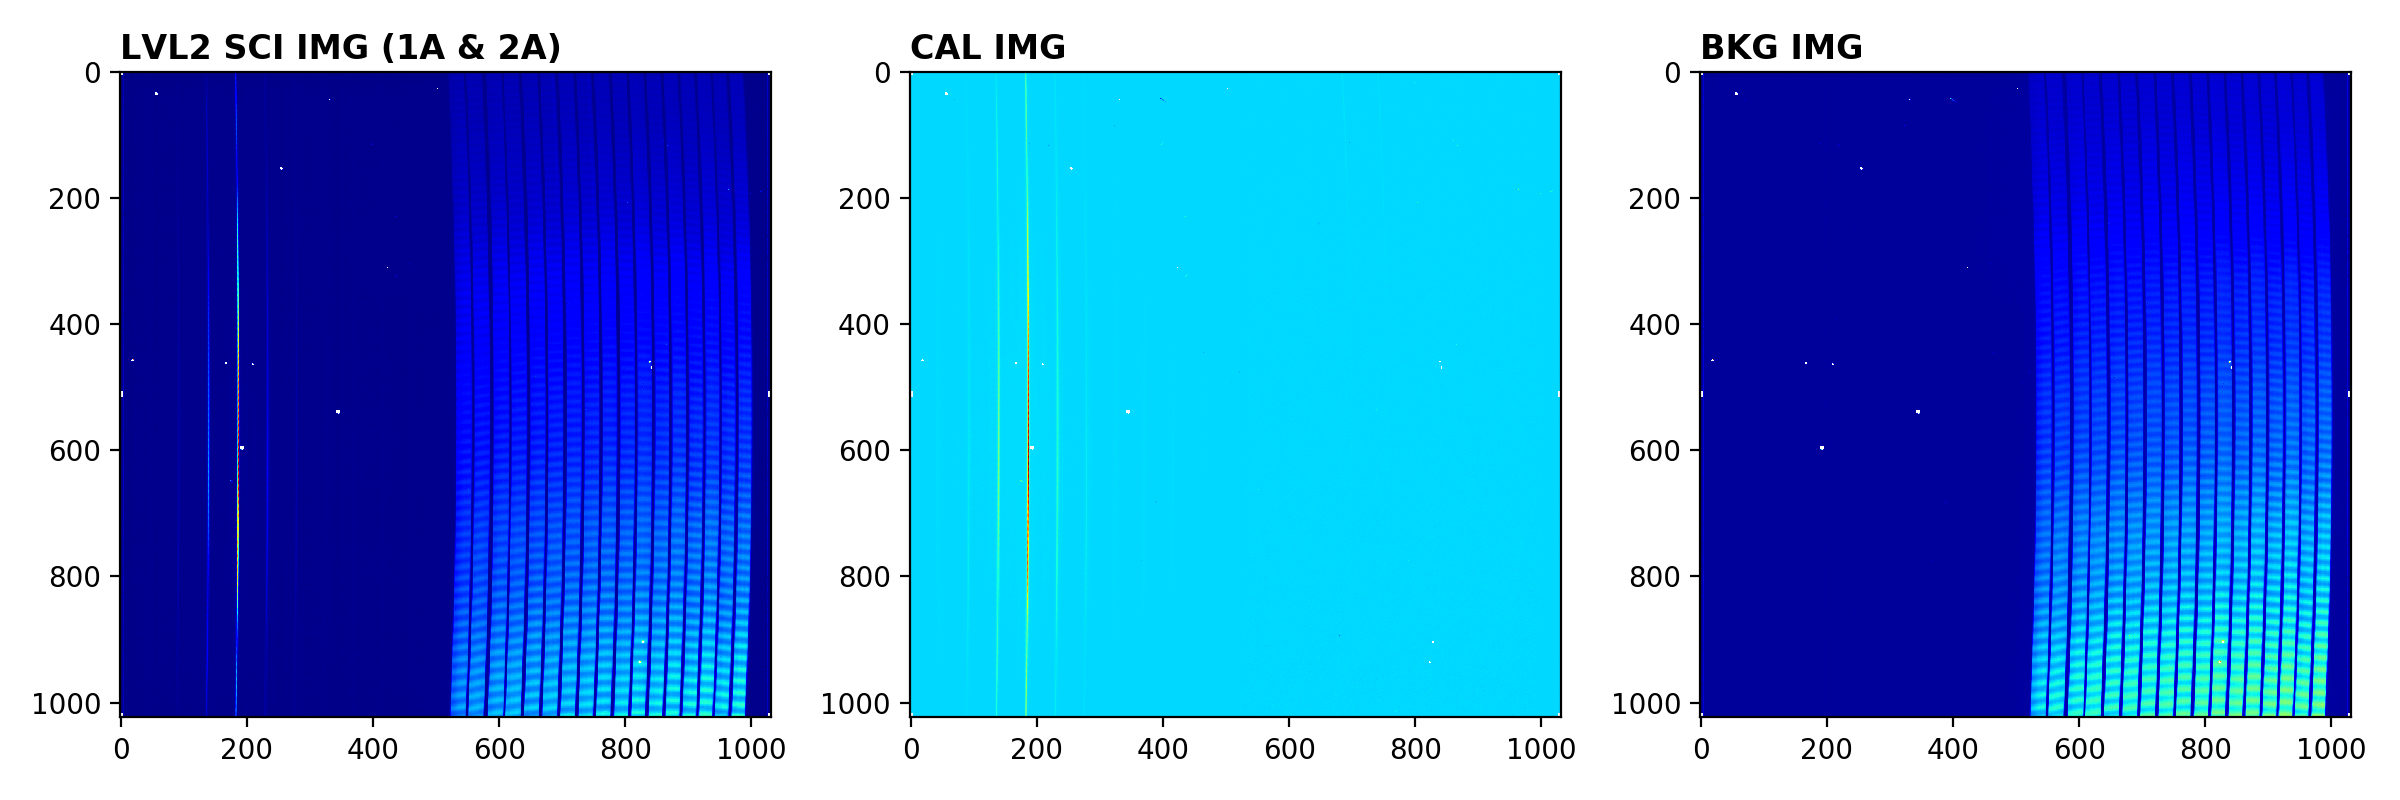

<IPython.core.display.Javascript object>


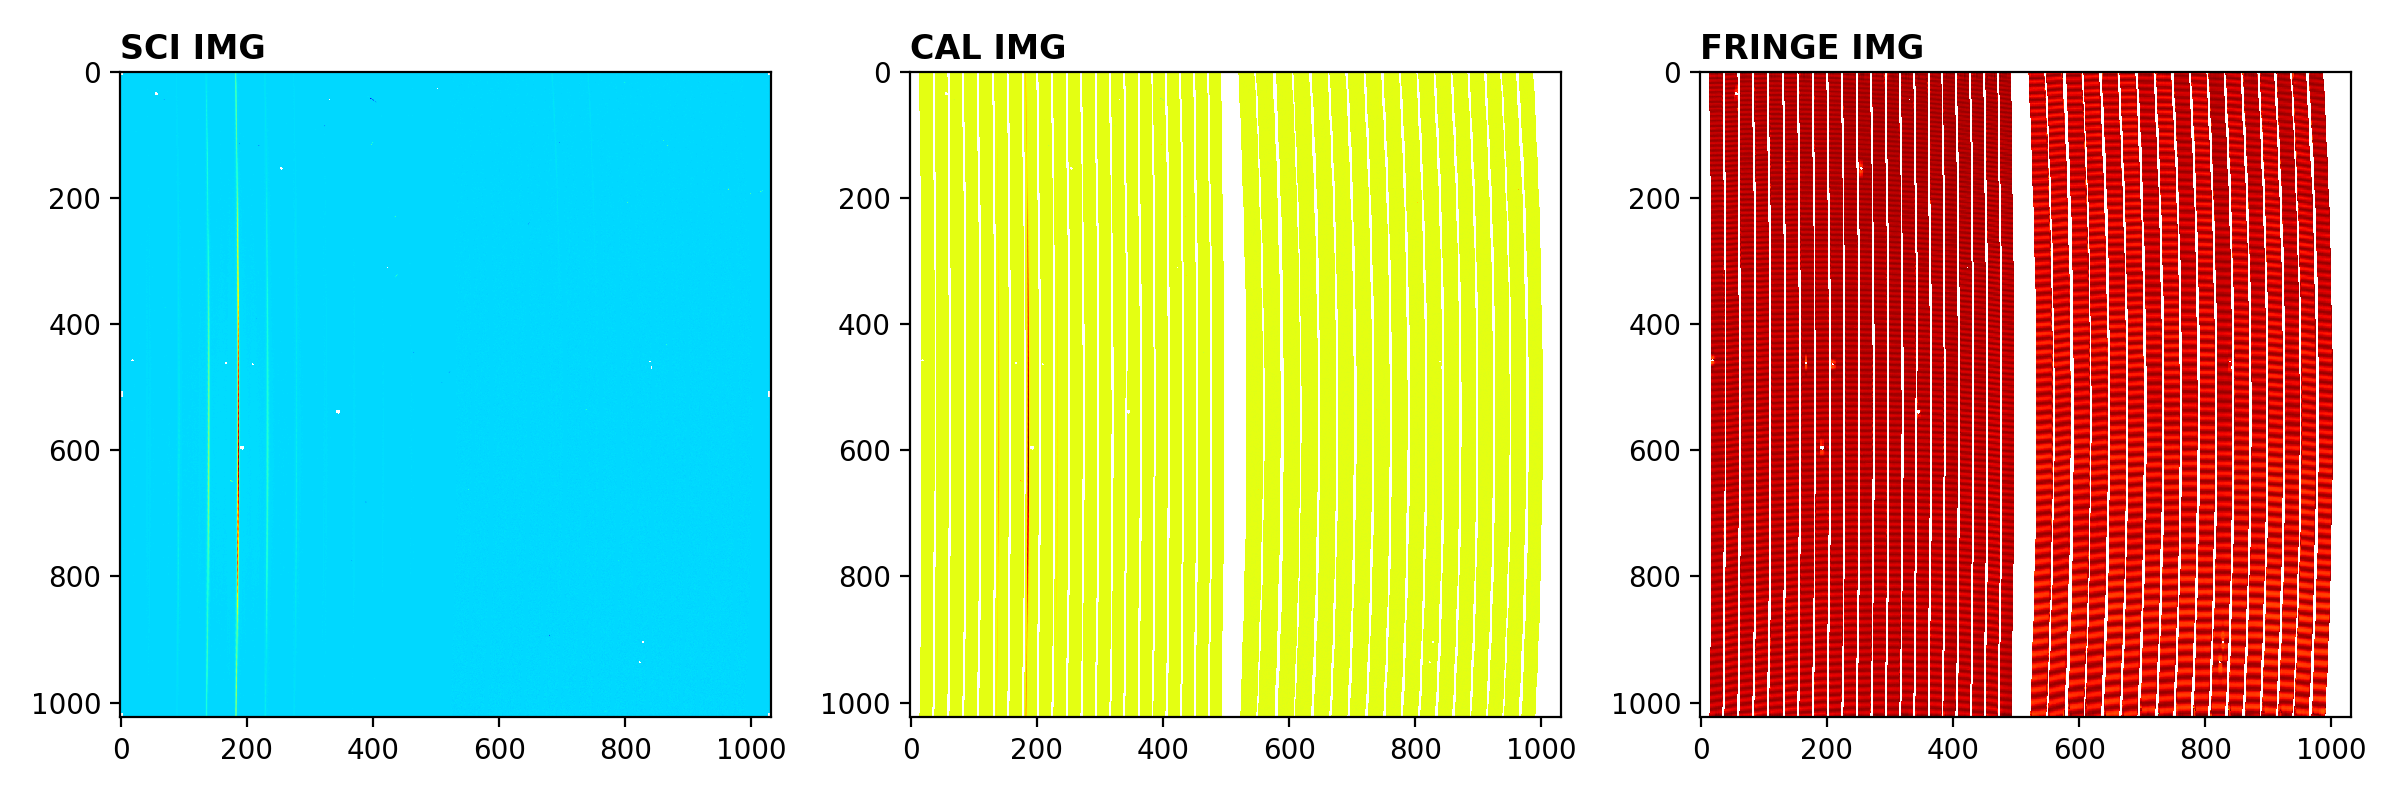

<IPython.core.display.Javascript object>


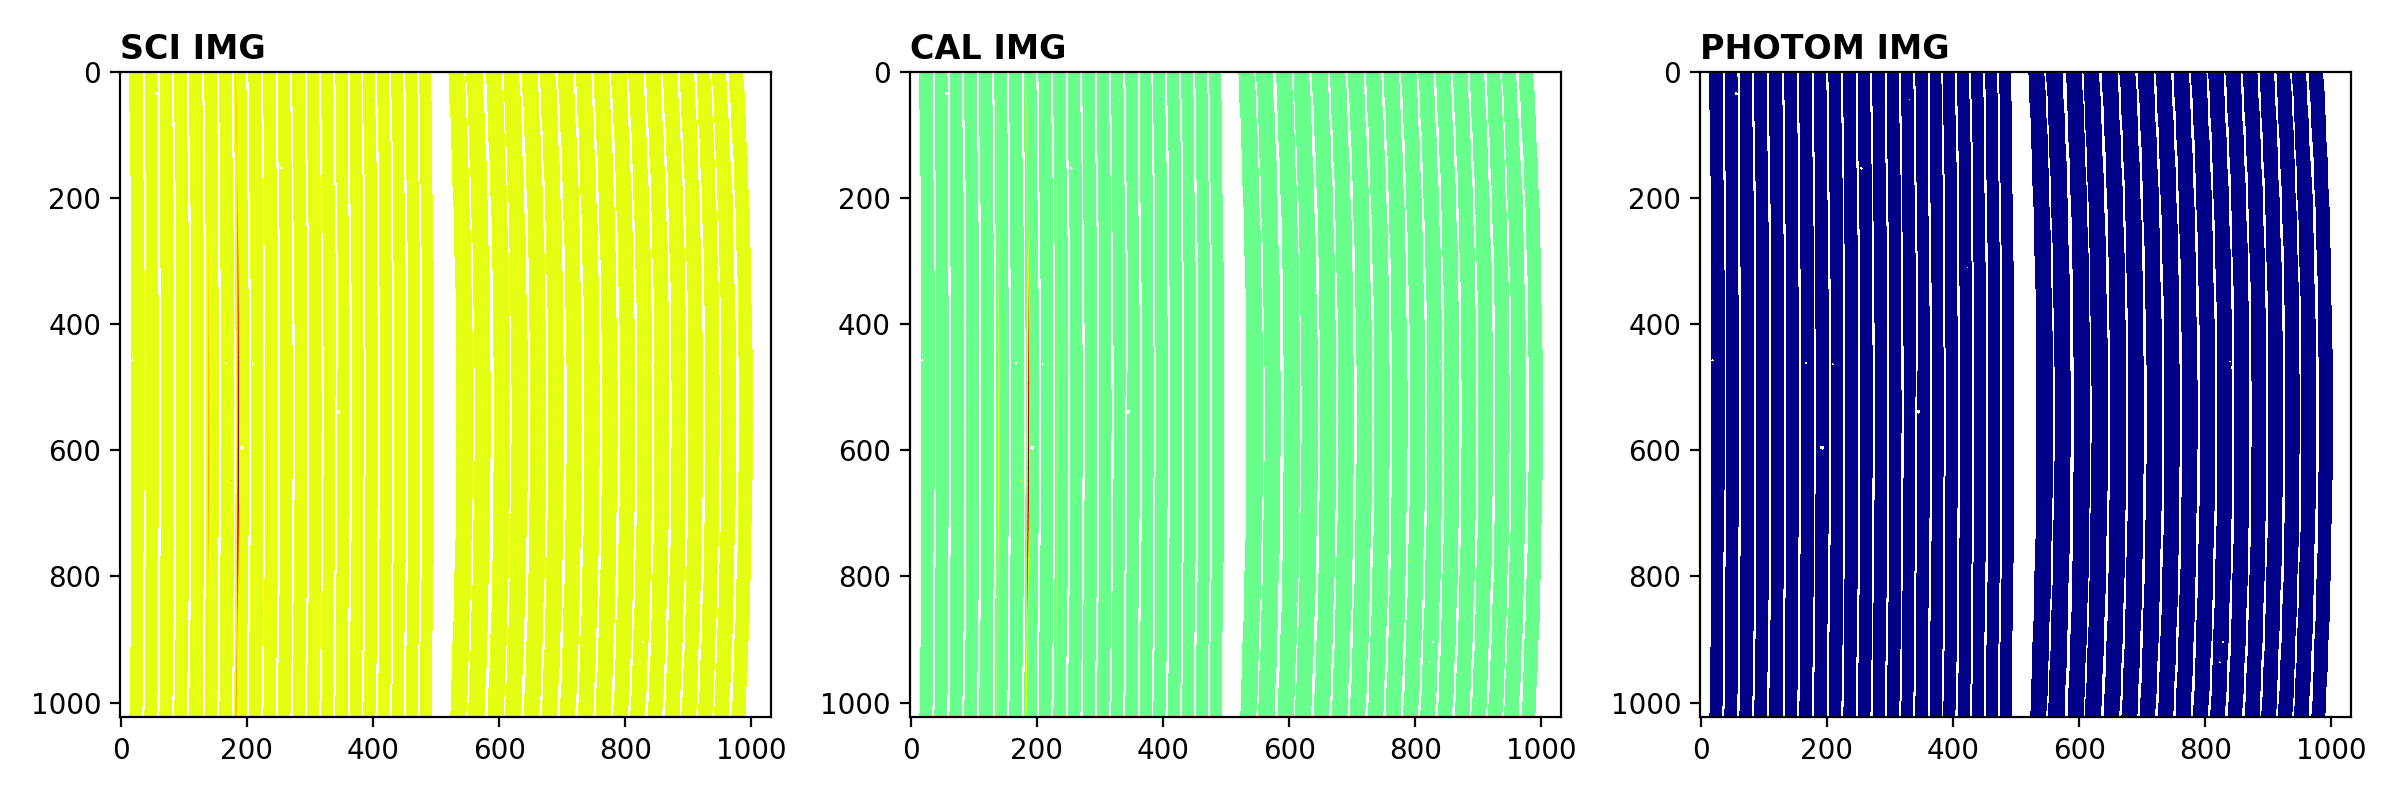

<IPython.core.display.Javascript object>


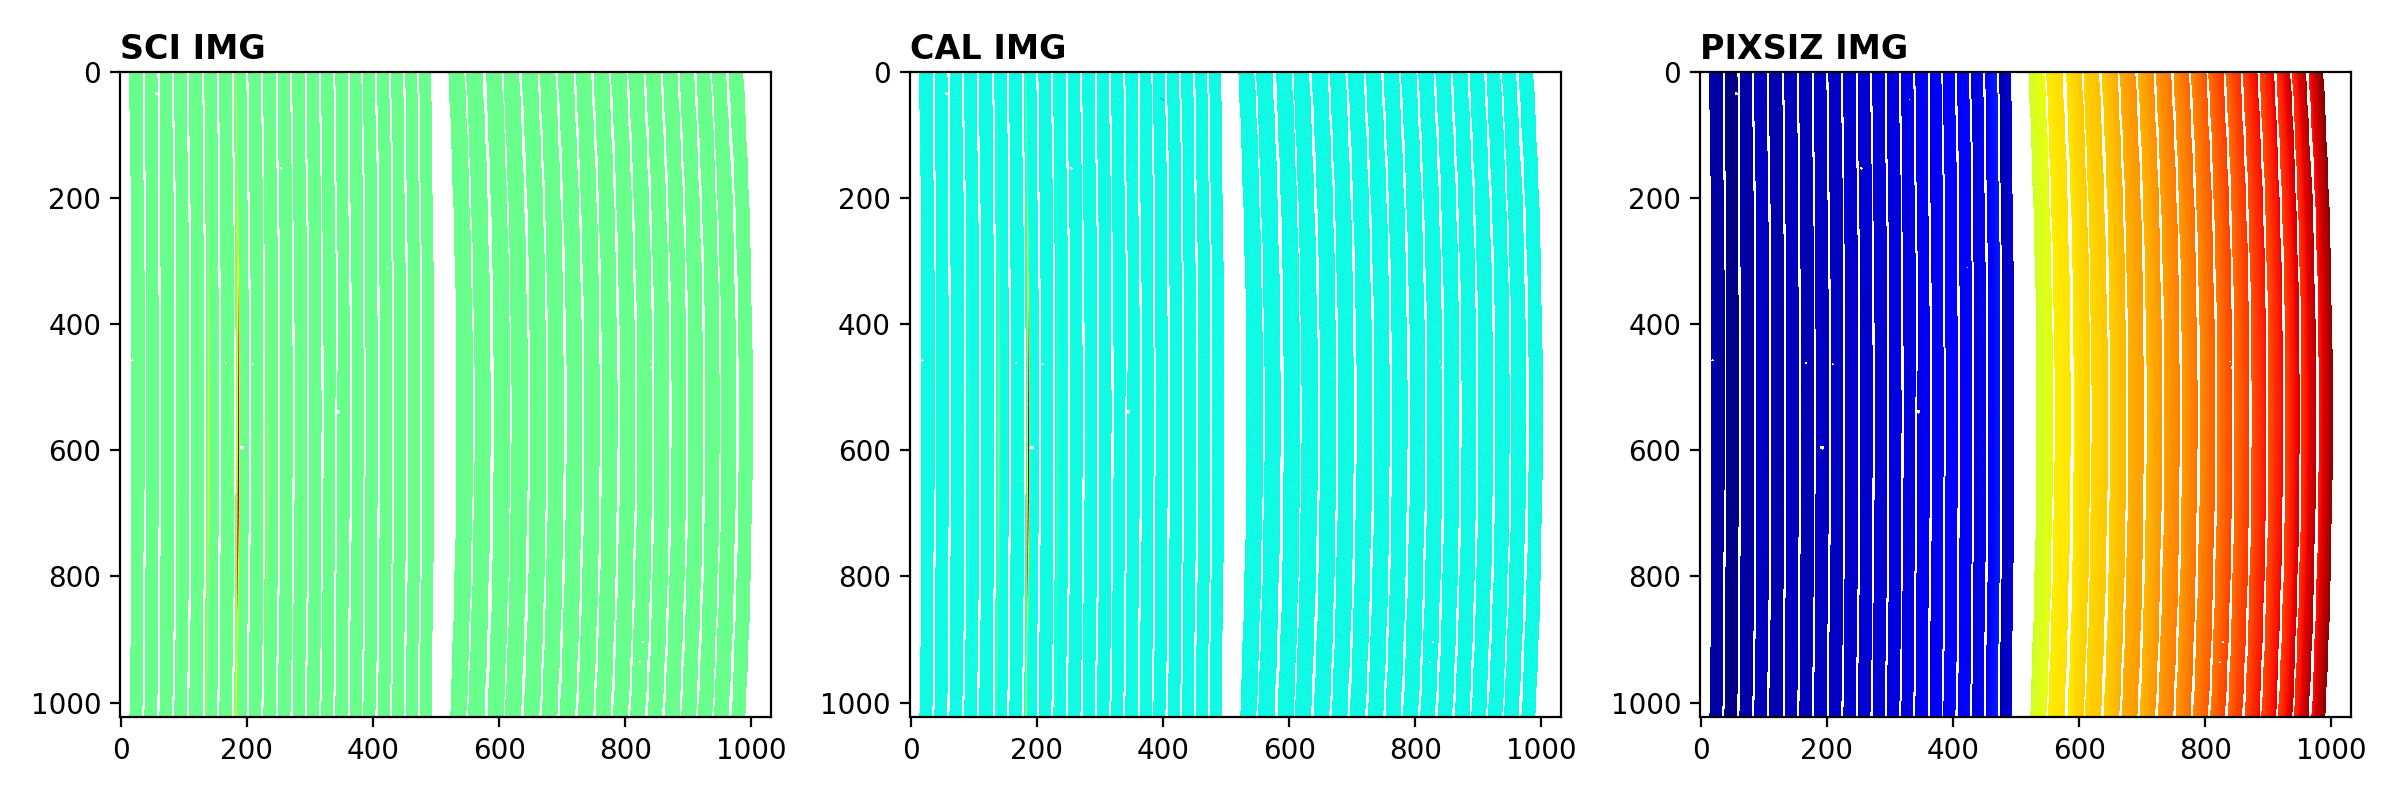

In [9]:
# How about the LVL2 to LVL3 calibration process? Let's look at that.
# First comes the background subtraction, note that the point source observation was performed only in band 1A (left side of the detector).
# The test setup was such that the background was minimized in the shorter MRS bands. It actually becomes more important in the longest wavelengths (channel 3 / channel 4)
fig,axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(source_signal,cmap='jet', interpolation='nearest')
axs[0].annotate('LVL2 SCI IMG (1A & 2A)', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(source_signal_subtrbkg,cmap='jet', interpolation='nearest')
axs[1].annotate('CAL IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(source_signal-source_signal_subtrbkg,cmap='jet', interpolation='nearest')
axs[2].annotate('BKG IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

# Next is the fringe correction. Unfortunately the calibration data product for the MRS fringing was derived from extended source data. 
# A reult of this is that significant fringing is left for point source observations. I am currently working on solving that problem.. TBD
fig,axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(source_signal_subtrbkg,cmap='jet', interpolation='nearest')
axs[0].annotate('SCI IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(source_signal_divfringe,cmap='jet', interpolation='nearest')
axs[1].annotate('CAL IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(source_signal_subtrbkg/source_signal_divfringe,cmap='jet', interpolation='nearest')
axs[2].annotate('FRINGE IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

# Finally there is the spectrophotometric correction, relating to the spectral response of each pixel on the detector.
fig,axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(source_signal_divfringe,cmap='jet', interpolation='nearest')
axs[0].annotate('SCI IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(source_signal_divphotom,cmap='jet', interpolation='nearest')
axs[1].annotate('CAL IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(source_signal_divfringe/source_signal_divphotom,cmap='jet', interpolation='nearest')
axs[2].annotate('PHOTOM IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

# As part of the spectrophotometric calibration, one also corrects for the inhomogeneous spatial size of the pixels.
fig,axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(source_signal_divphotom,cmap='jet', interpolation='nearest')
axs[0].annotate('SCI IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].imshow(source_signal_divpixsiz,cmap='jet', interpolation='nearest')
axs[1].annotate('CAL IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[2].imshow(source_signal_divphotom/source_signal_divpixsiz,cmap='jet', interpolation='nearest')
axs[2].annotate('PIXSIZ IMG', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
plt.tight_layout()

<IPython.core.display.Javascript object>


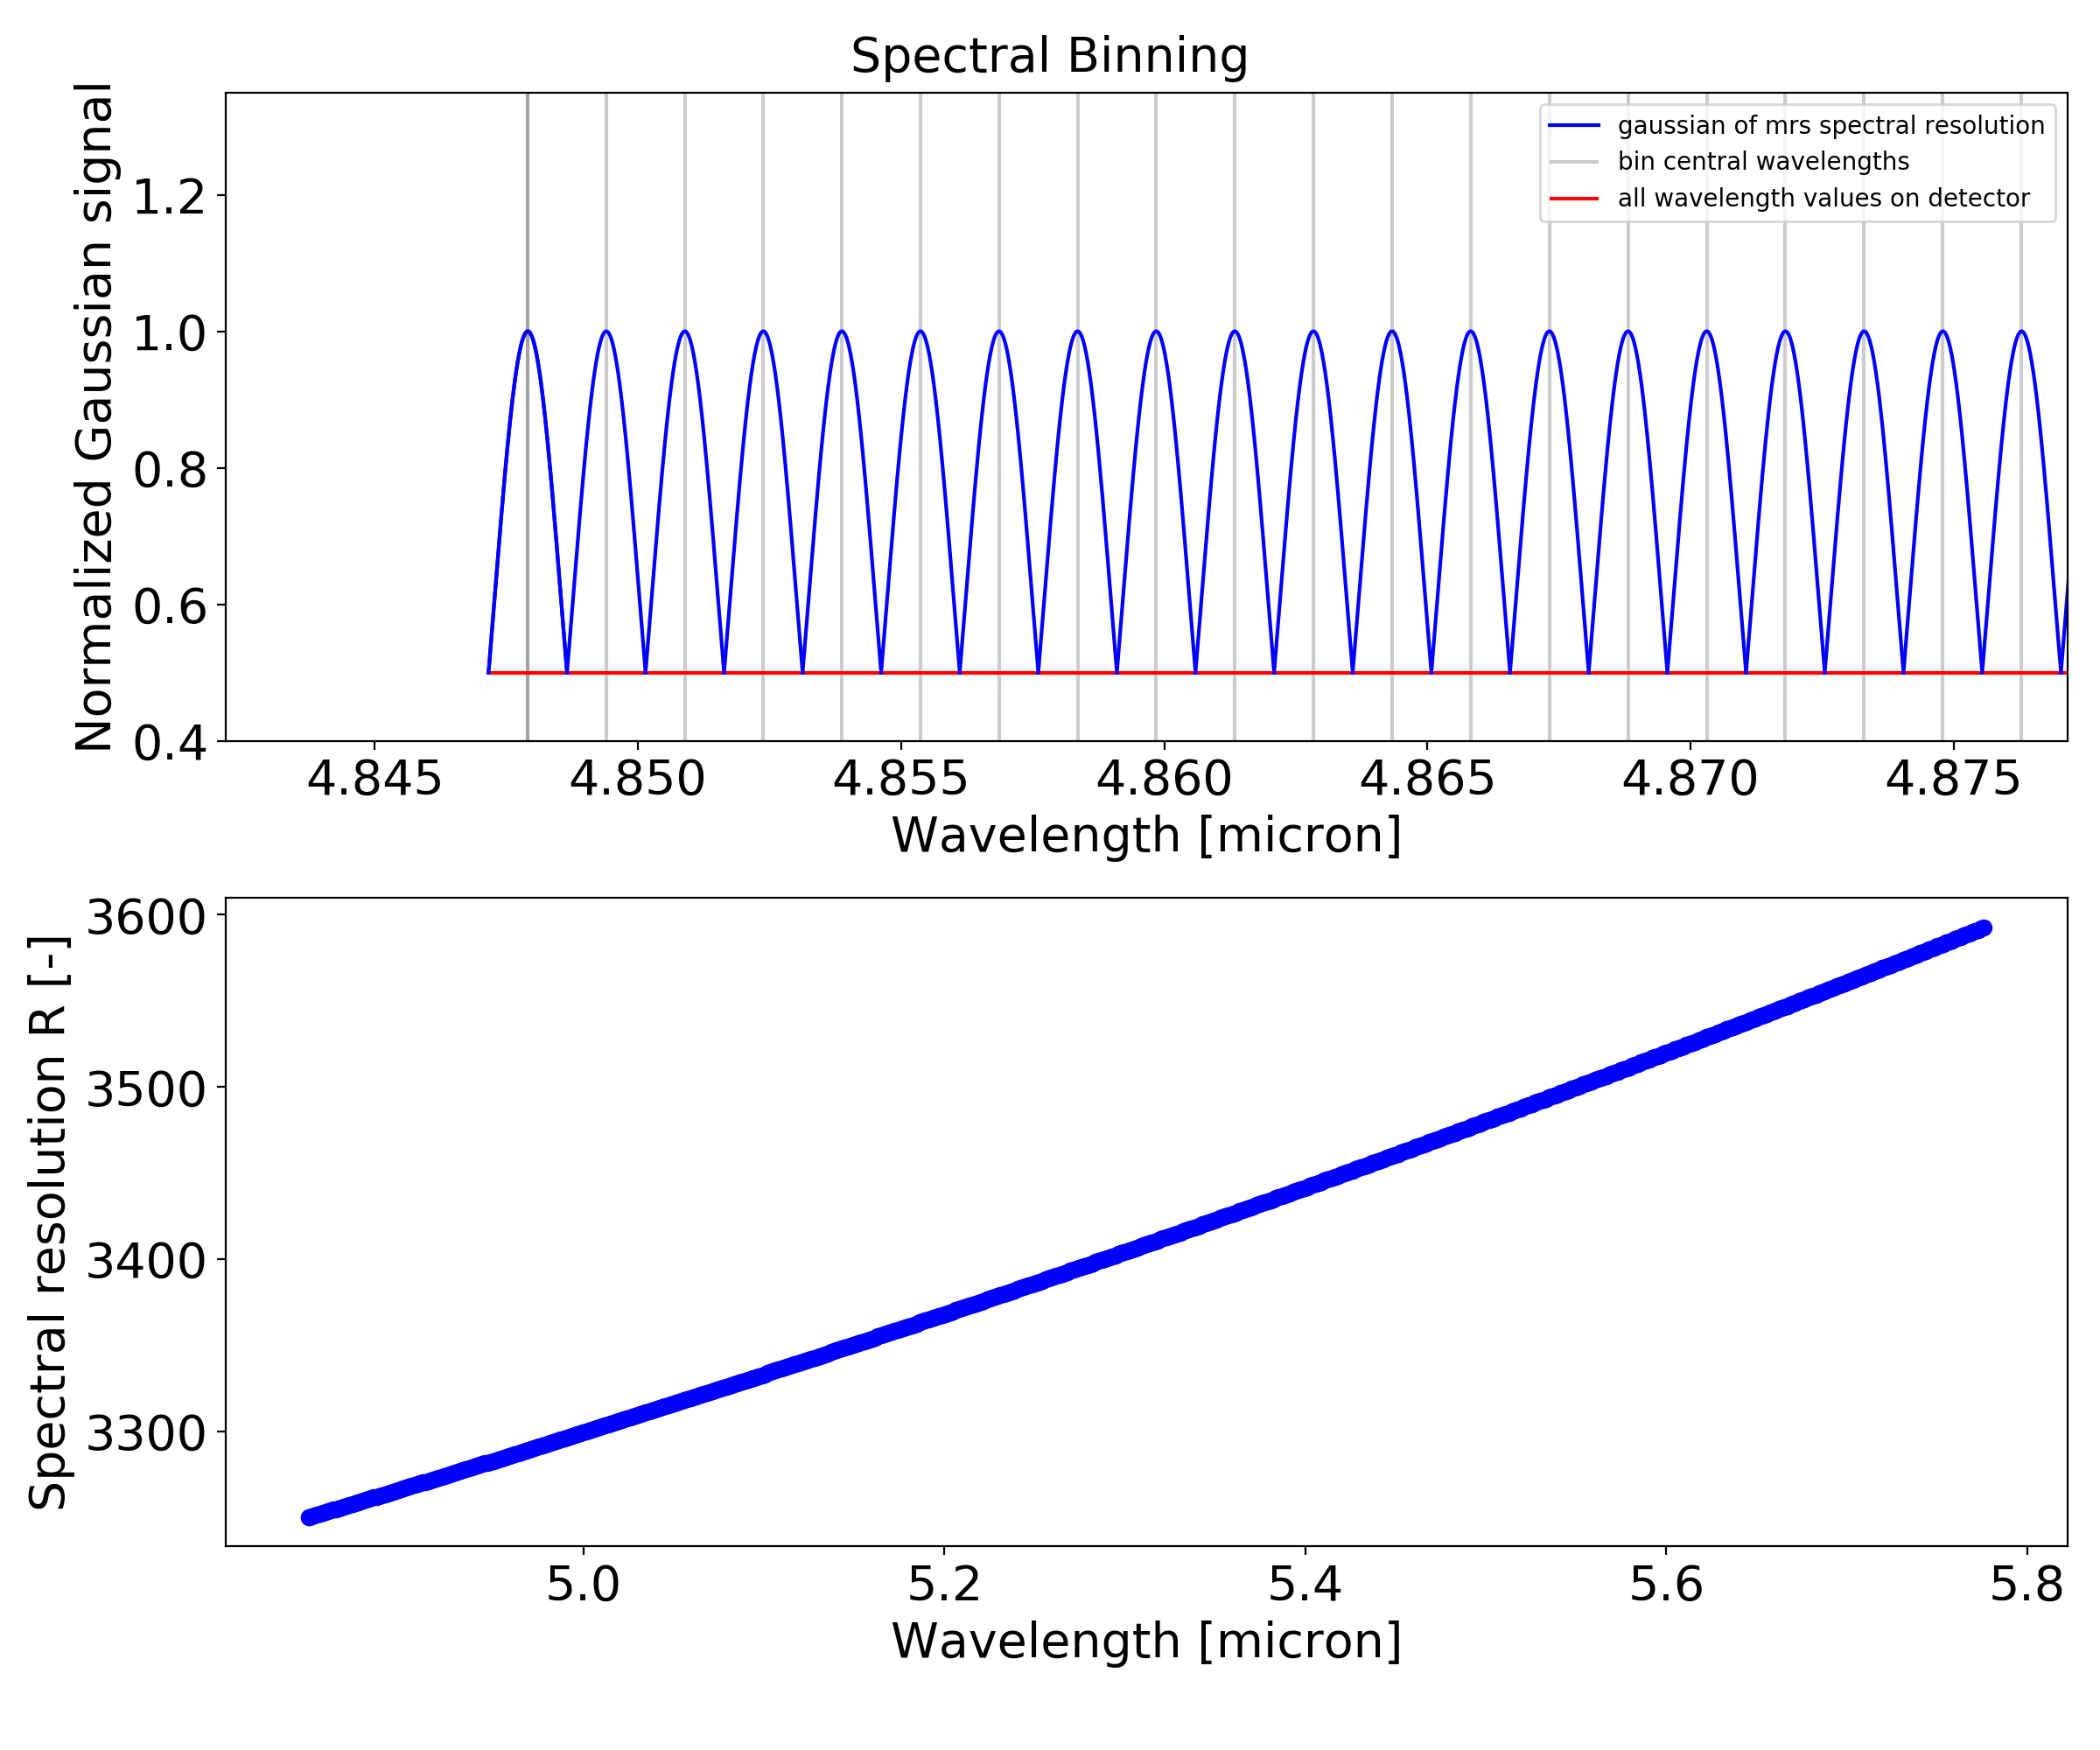

In [10]:
# After calibration comes the "modeling" part of this notebook. The first thing we did was construct a spectral grid.
# What I show below is the central wavelength and width of each spectral bin in the constructed grid. I also show the resolution used to derive the former values.
# Detector pixels of which the wavelength coordinate falls within the width of a bin, are assigned to that bin.
fig,axs = plt.subplots(2,1,figsize=(12,10))
for ibin in range(len(lambcens)):
    sigma = lambfwhms[ibin]/2.355
    x = np.linspace(lambcens[ibin]-lambfwhms[ibin]/2,lambcens[ibin]+lambfwhms[ibin]/2,1000)
    y = funcs.gauss1d_wBaseline(x,1.,lambcens[ibin],sigma,0)
    axs[0].plot(x,y,'b')
    axs[0].vlines(lambcens[ibin],0.3,1.4,alpha=0.2)
    R = funcs.getSpecR(lamb0=lambcens[ibin],band=band,specres_table=specres_table)
    axs[1].plot(lambcens[ibin],R,'bo')
bandlims = [d2cMaps['lambdaMap'][np.nonzero(d2cMaps['lambdaMap'])].min(),d2cMaps['lambdaMap'][np.nonzero(d2cMaps['lambdaMap'])].max()]
axs[0].plot(x,y,'b',label='gaussian of mrs spectral resolution')
axs[0].vlines(lambcens[ibin],0.3,1.4,alpha=0.2,label='bin central wavelengths')
axs[0].hlines(0.5,bandlims[0],bandlims[1],'r',label='all wavelength values on detector')
axs[0].set_xlim(bandlims[0]-0.005,bandlims[0]+0.03)
axs[0].set_ylim(0.4,1.35)
axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
axs[0].set_ylabel('Normalized Gaussian signal',fontsize=20)
axs[0].legend(loc='upper right')
axs[0].tick_params(axis='both',labelsize=20)
axs[1].set_xlabel('Wavelength [micron]',fontsize=20)
axs[1].set_ylabel('Spectral resolution R [-]',fontsize=20)
axs[1].tick_params(axis='both',labelsize=20)
plt.suptitle('Spectral Binning',fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])

<IPython.core.display.Javascript object>


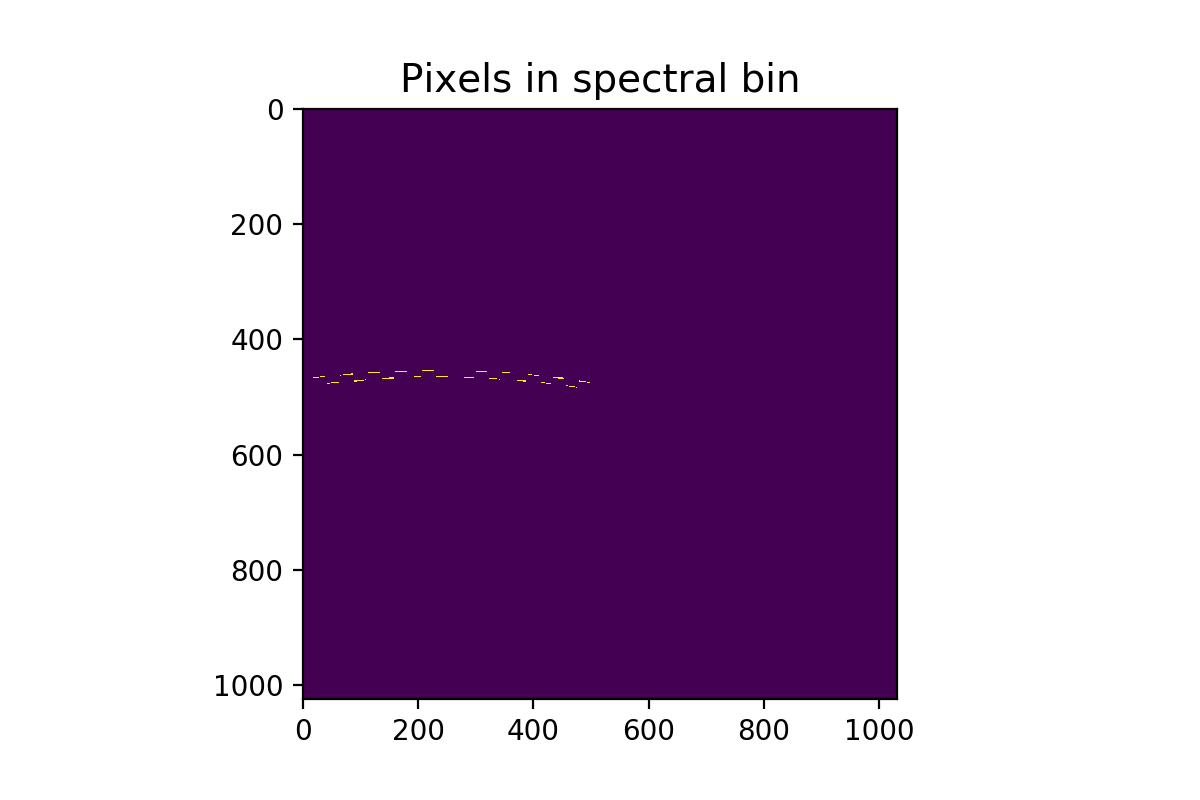

<IPython.core.display.Javascript object>


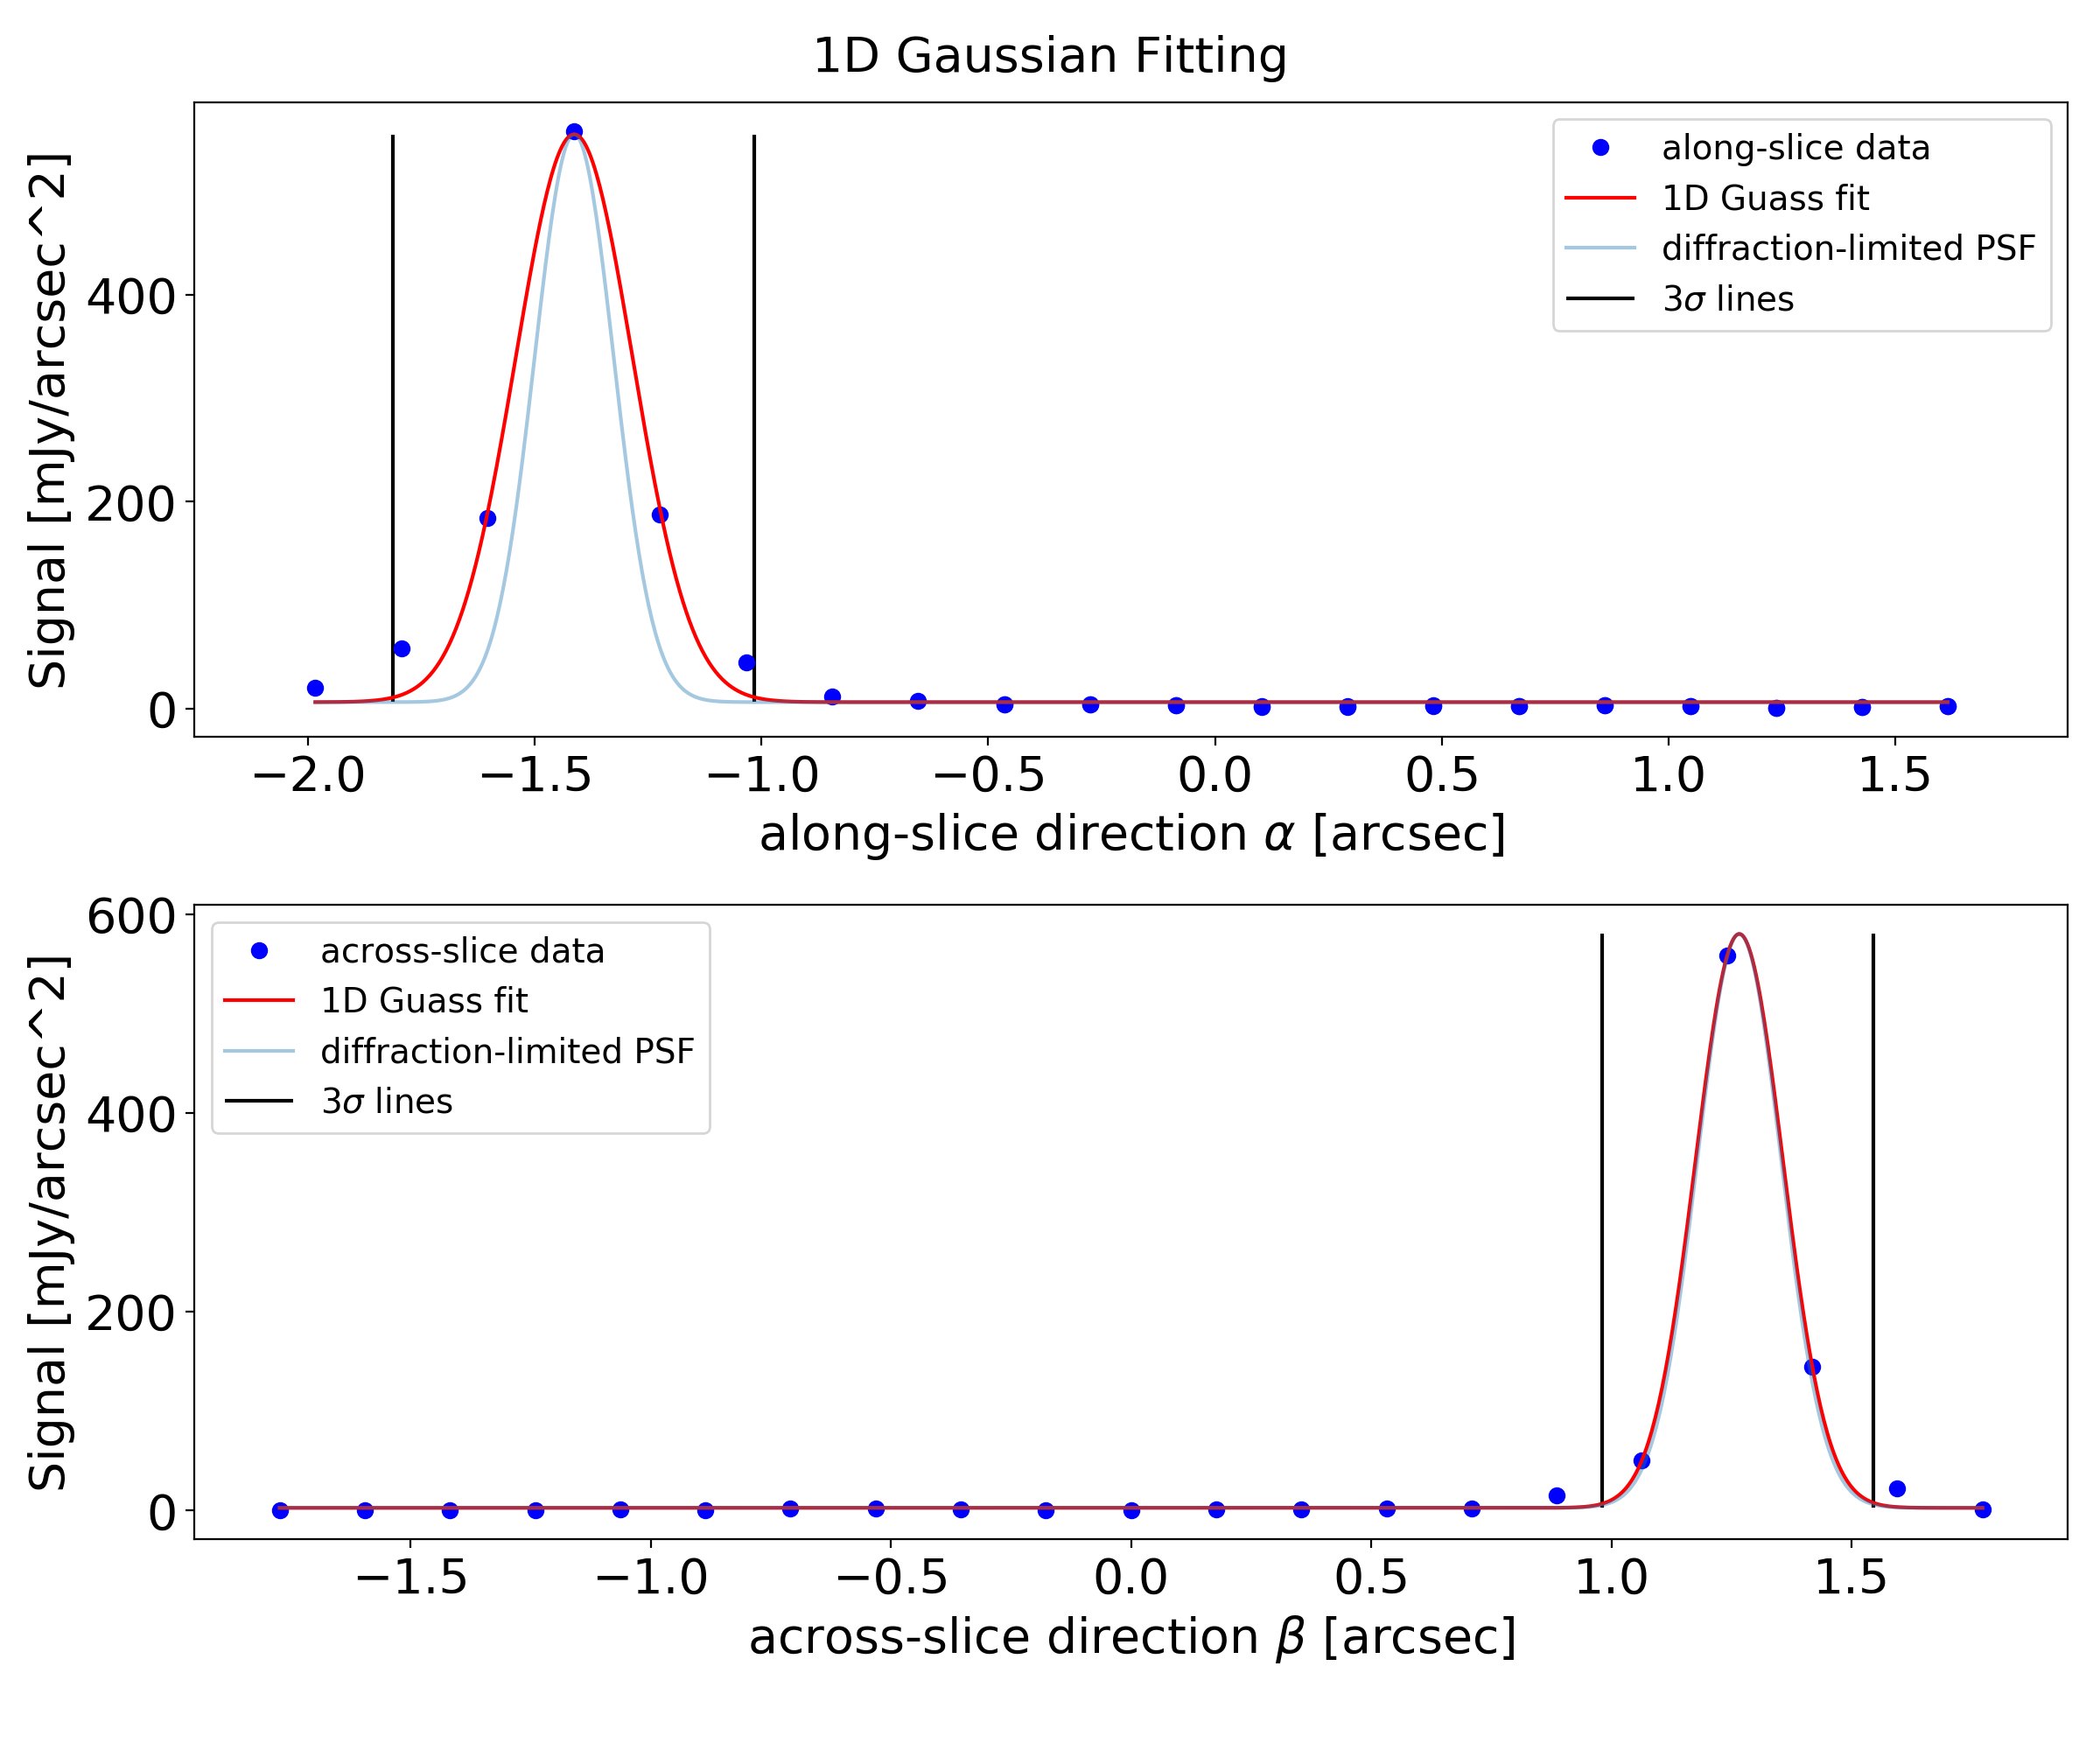

<IPython.core.display.Javascript object>


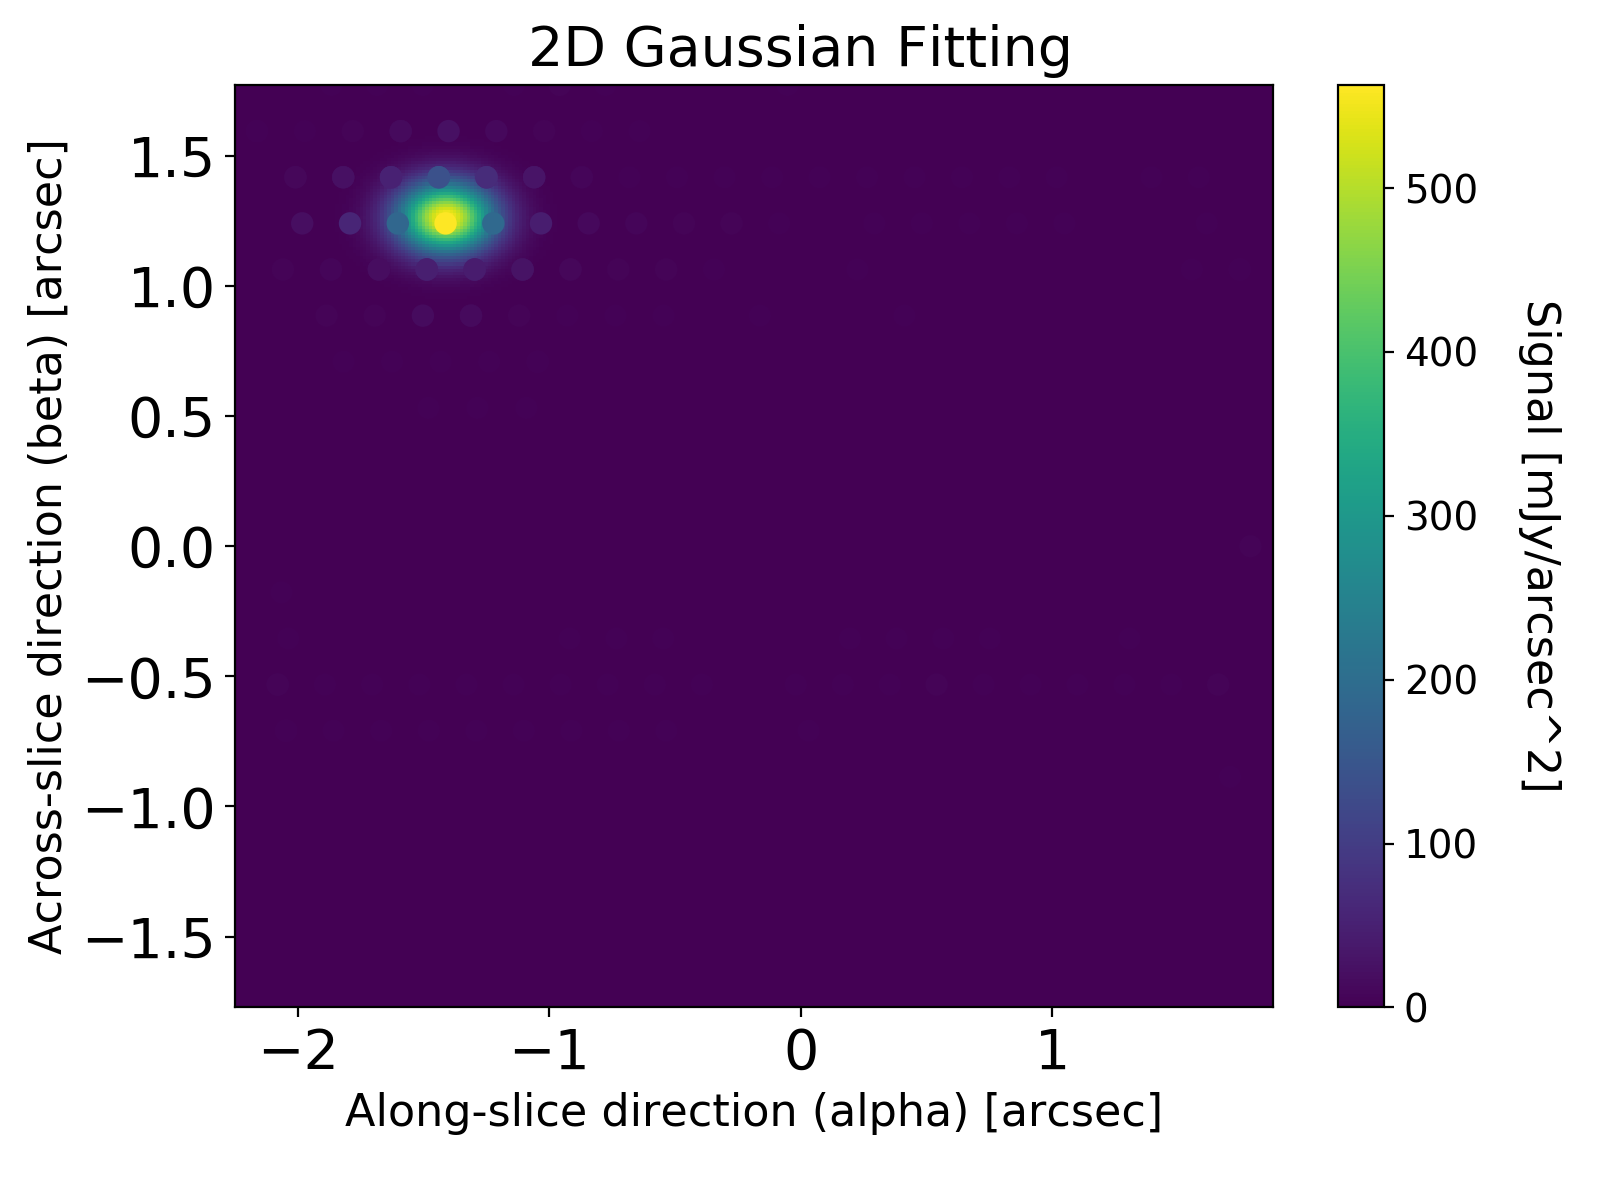

<IPython.core.display.Javascript object>


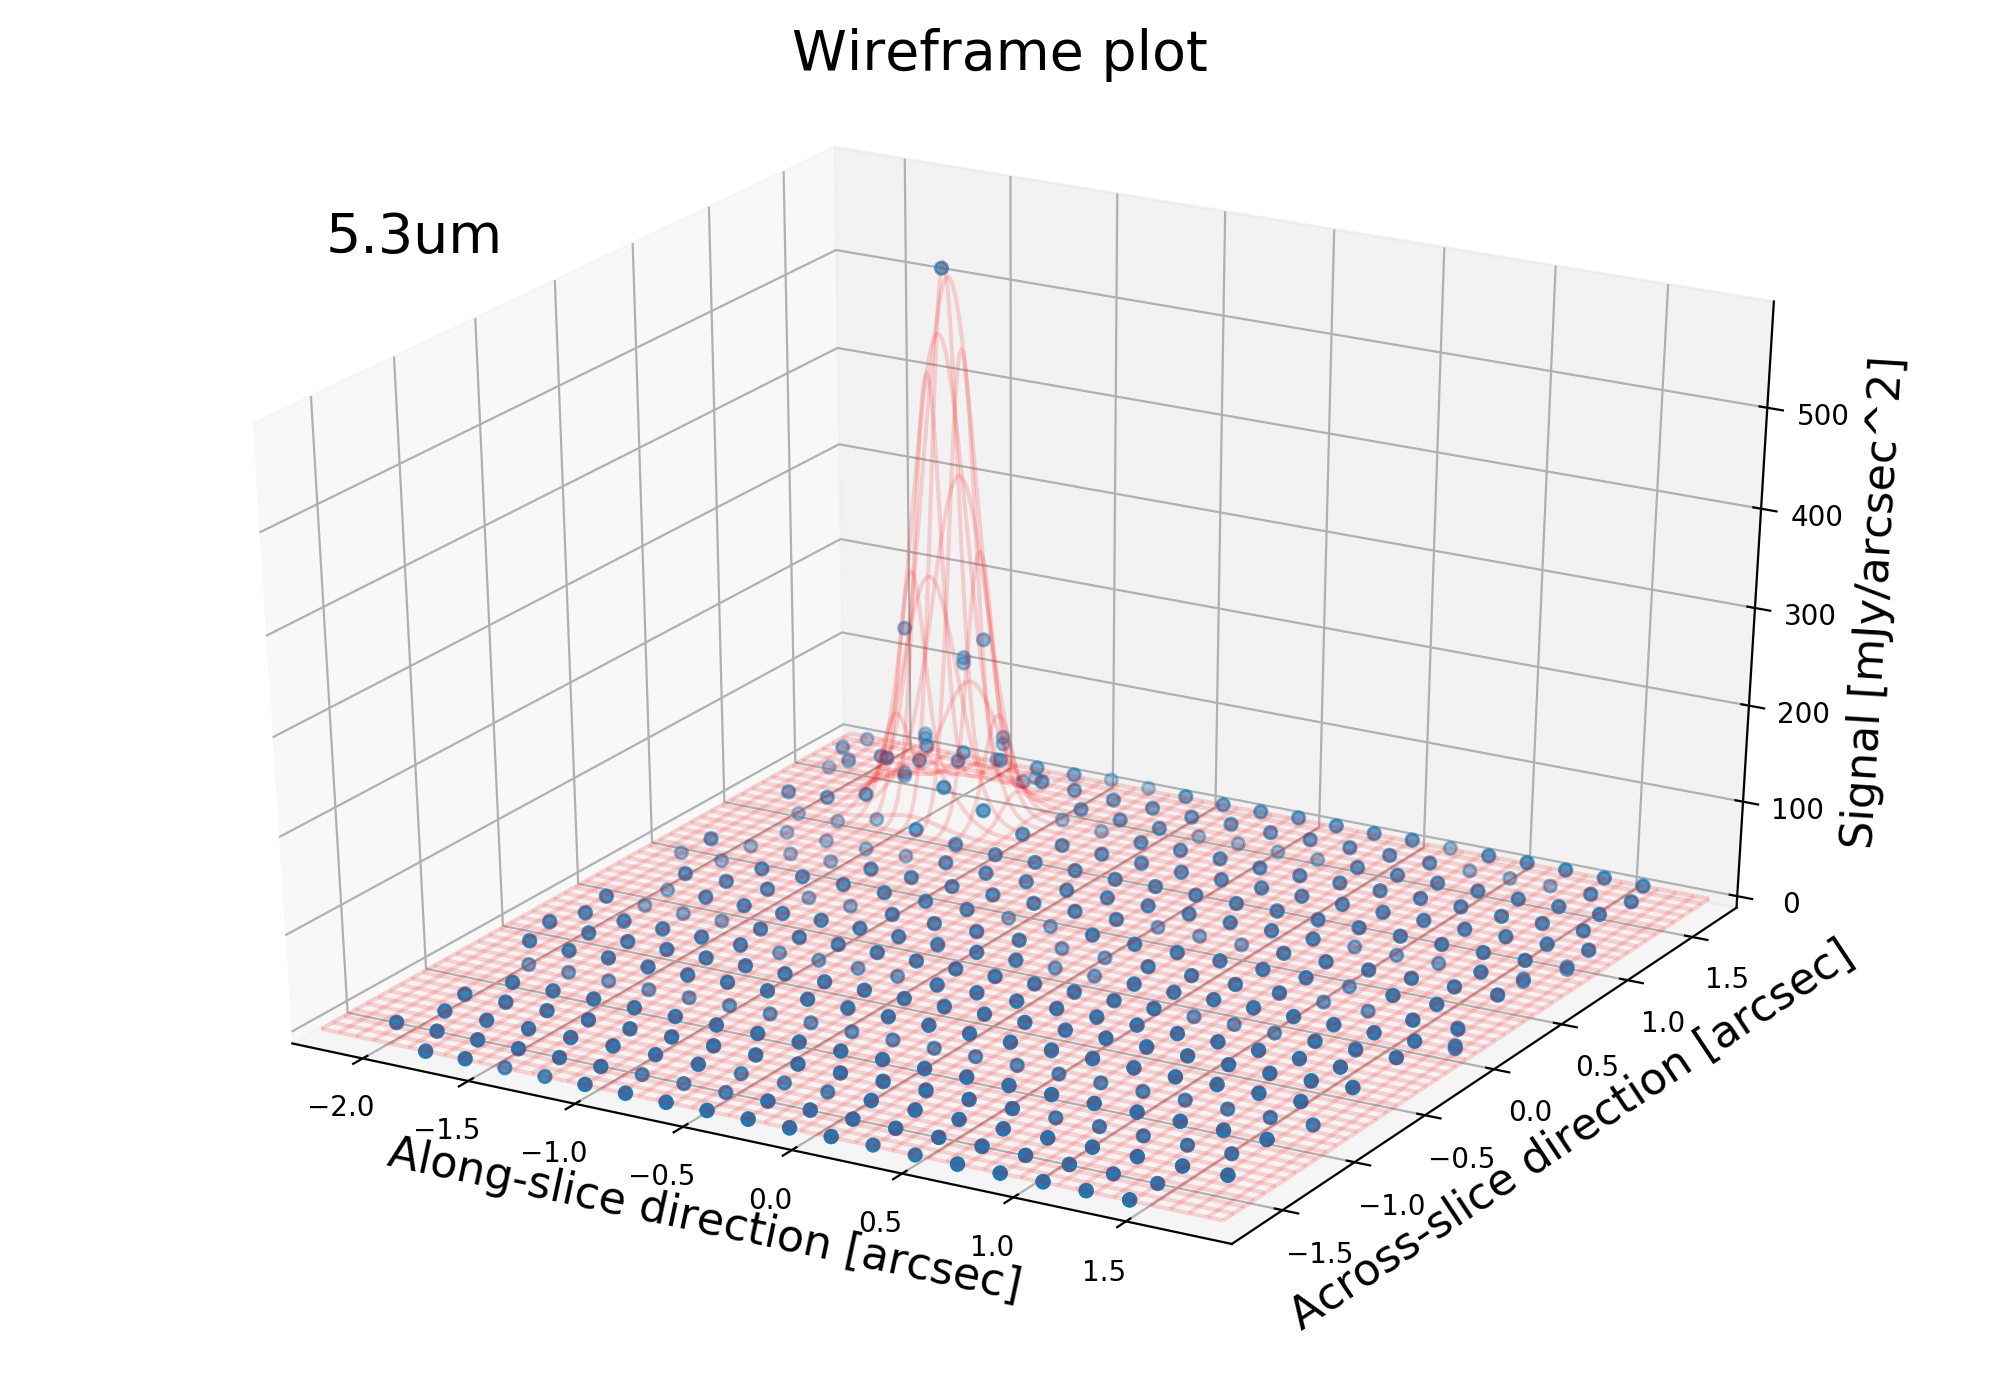

In [11]:
# With the spectral grid information available, the centroid of the source is then determined at every wavelength.
# "One wavelength" is defined as one spectral bin. Taking for instance the bin in the middle of spectral band wavelength range,
# all pixels within half a resolution element are appended to that bin. This is shown in the first plot below (the bright pixels in different slices).
ibin = len(lambcens)/2 +1
selectedpixelMap = np.zeros(det_dims)
selectedpixelMap[(np.abs(d2cMaps['lambdaMap']-lambcens[ibin])<lambfwhms[ibin]/2.)] = 1.
plt.figure(figsize=(6,4))
plt.imshow(selectedpixelMap,interpolation='None')
plt.title('Pixels in spectral bin',fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

# In a first instance the centroid of the source is calculated in one dimension. This is done by finding the centroid in one spatial direction, looking at the signal in one slice (the slice with the highest signal).
# The centroid in the second spatial direction is determined using the signal of the pixels of each slice that are closest to the first spatial center. This means that the number of datapoints for this fit is exactly equal to the number of slices (21 points, equal to 21 slices, in band 1A).
# Lastly, in order to refine the centroid further, the previous position estimates are used as inputs for a 2D Gaussian fitting. What is fitted is a 2D scatter plot with all the pixel values in a spectral bin (i.e. all slices are accounted for). These pixels have two spatial dimensions, and that is what is used to fit the model function.
funcs.plot_point_source_centroiding(band=band,sci_img=source_signal_divpixsiz,d2cMaps=d2cMaps,spec_grid=[lambcens,lambfwhms],centroid=[sign_amp,alpha_centers,beta_centers,sigma_alpha,sigma_beta],ibin=ibin)

<IPython.core.display.Javascript object>


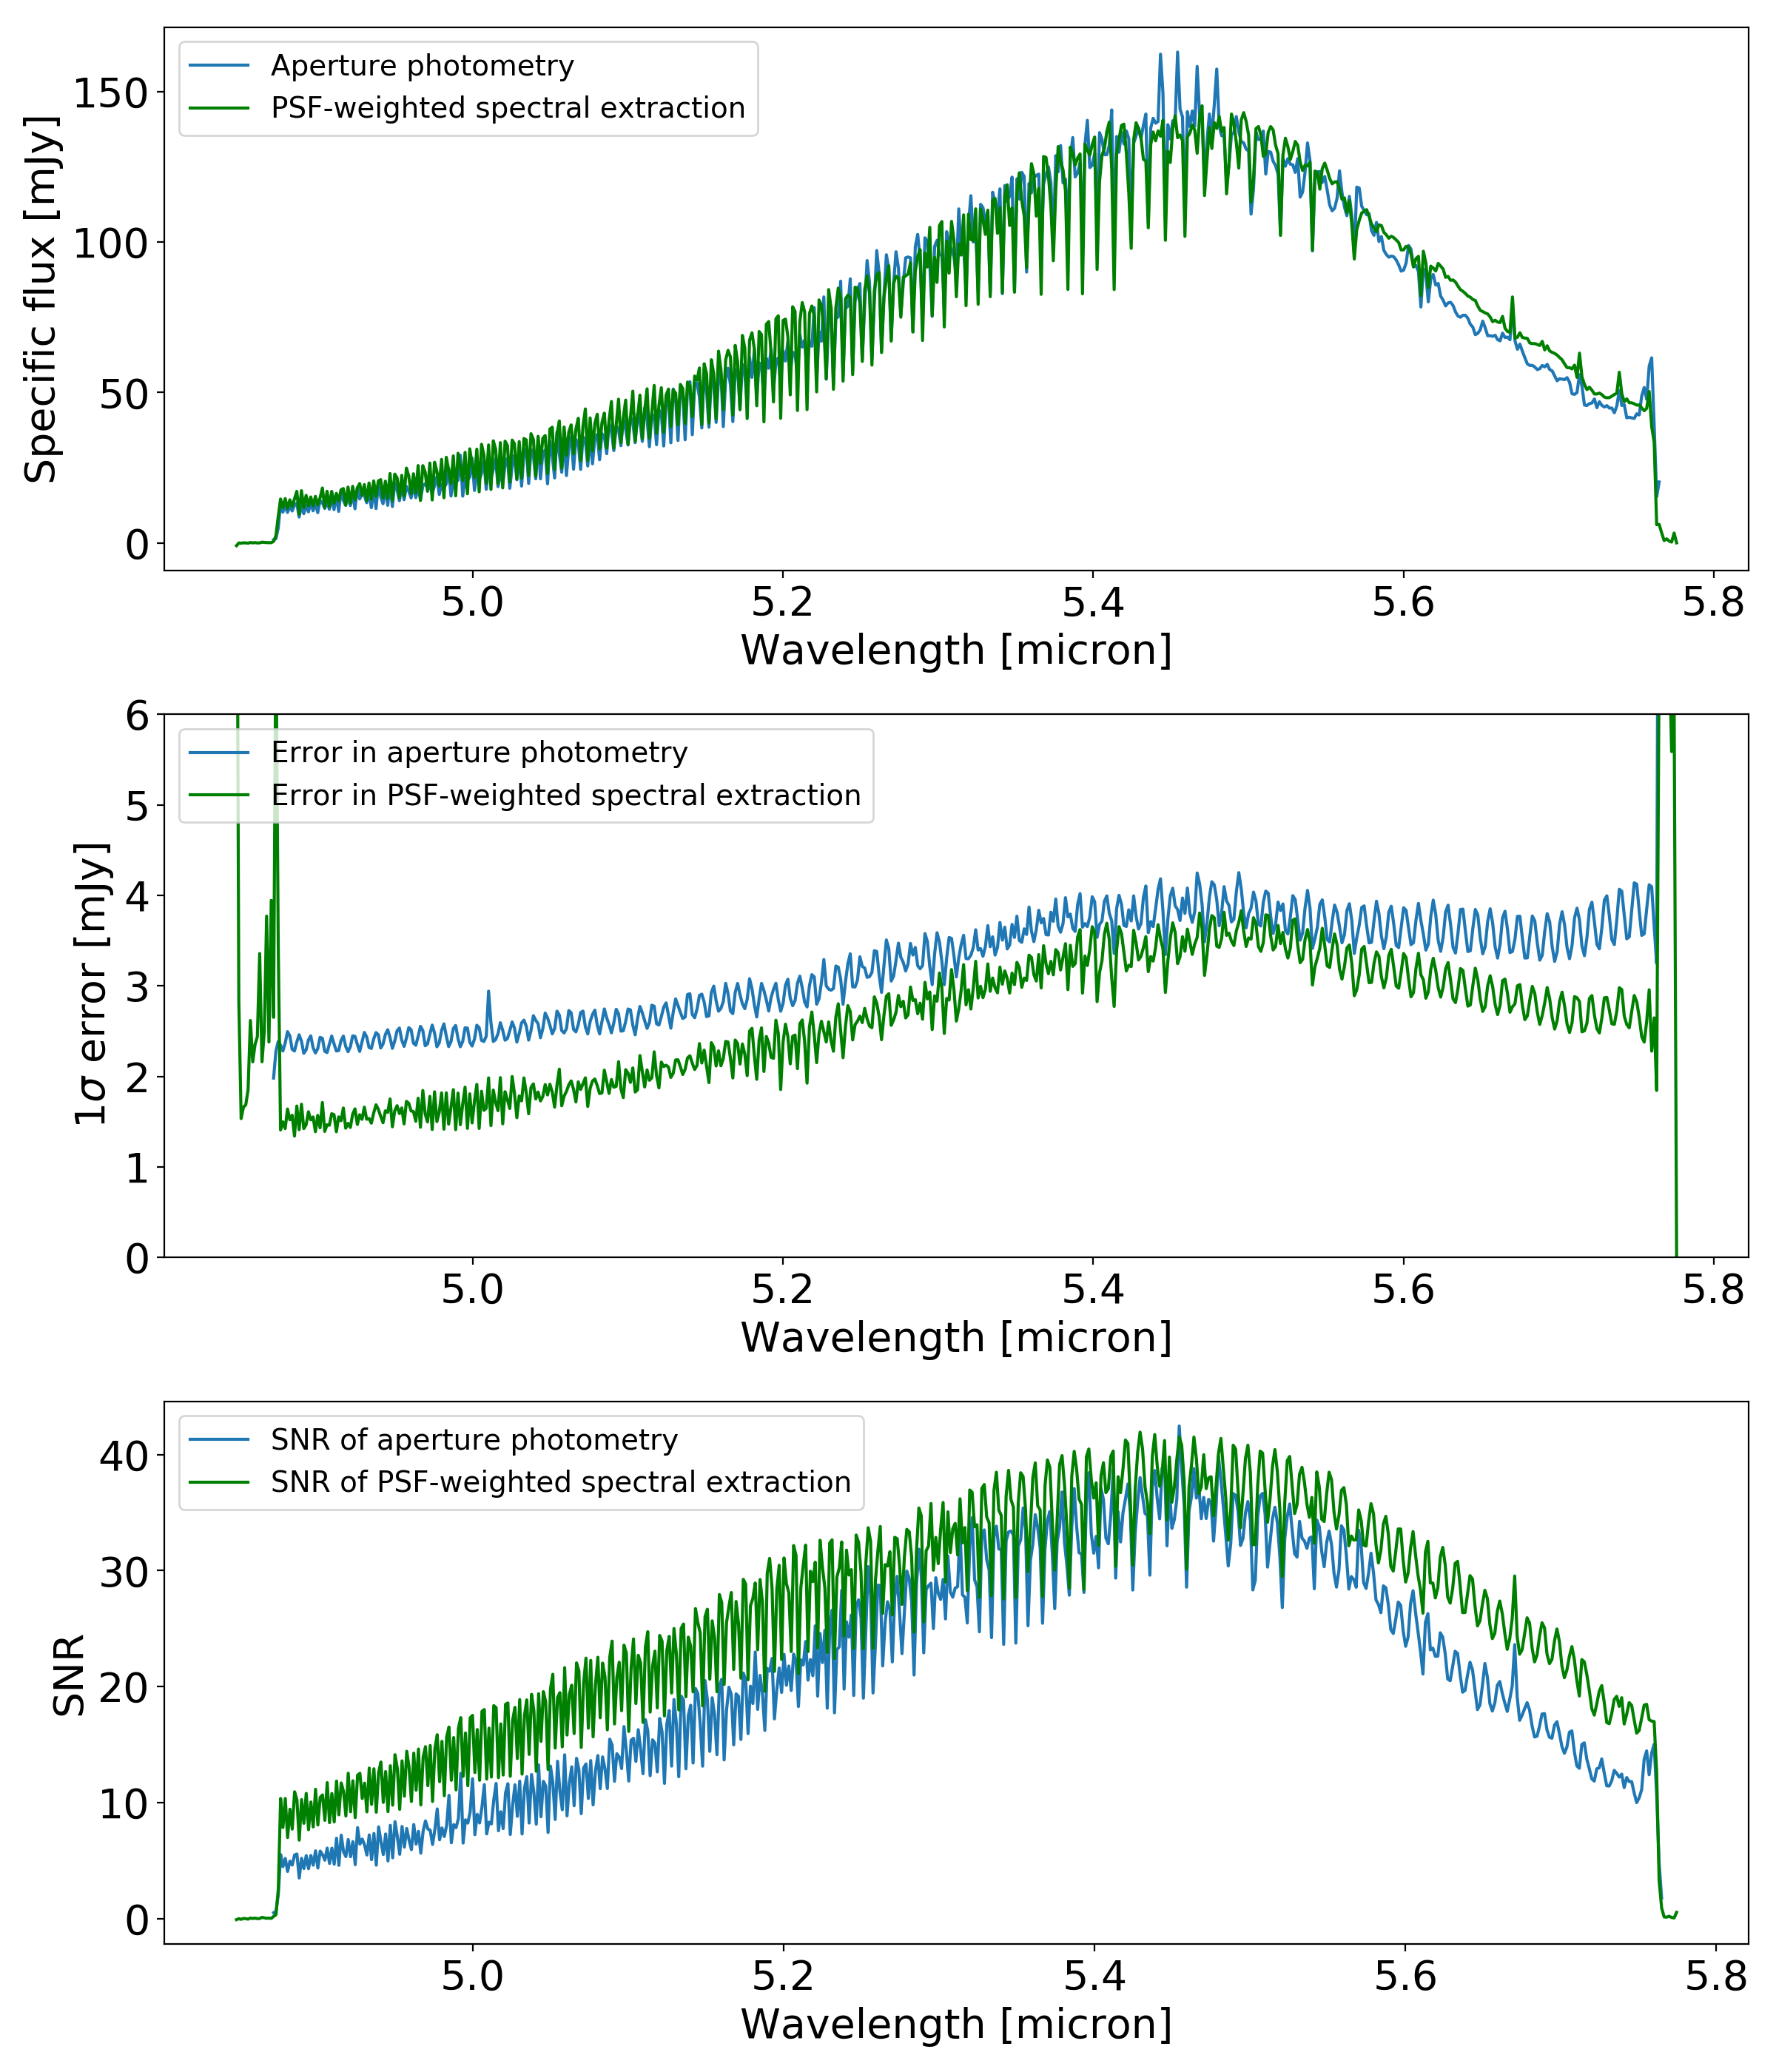

In [13]:
# So by this point we have:
# (1) loaded the reference distortion maps
# (2) calibrated the input data from LVL2 to LVL3 (slopes to surface brightness)
# (3) constructed a spectral grid based on the MRS spectral resolution
# (4) determined the source centroid in the MRS FOV
# Plots have been shown for each of these steps, so let's also plot the extracted source 1D spectrum.
# Recall that this one was measured using aperture photometry (with and without aperture correction) and also employing a PSF-weighted spectral extraction.
fig,axs = plt.subplots(3,1,figsize=(12,14))
axs[0].plot(lambcens,aperture_extracted_signal,label='Aperture photometry')
# axs[0].plot(lambcens,aperture_extracted_signal_apercorr,label='Aperture corrected photometry')
axs[0].plot(lambcens,opspec_signal,'g',label='PSF-weighted spectral extraction')
axs[0].set_xlabel('Wavelength [micron]',fontsize=20)
axs[0].set_ylabel('Specific flux [mJy]',fontsize=20)
axs[0].legend(loc='upper left',fontsize=14)
axs[0].tick_params(axis='both',labelsize=20)

# Note that any remarks about the curves in the first plot, at this point, can only be of a qualitative nature. The reason (mainly) is that there is still work to be done on the fringe front.
# Nevertheless the three spectra are indeed similar. The difference, mind you, lies in what the signal represents. 
# All three spectra come with units of specific flux (i.e. Janskys), however the noise properties of each spectrum are different.
# If we plot the propagated error, for the case of aperture photometry and optimal extraction, one notices an appreciable difference where the signal is noisier.
# Namely the optimal extraction uses the noise information to optimize the extraction of the pixel values.
axs[1].plot(lambcens,aperture_extracted_signal_error,label='Error in aperture photometry')
axs[1].plot(lambcens,opspec_signal_error,'g',label='Error in PSF-weighted spectral extraction')
axs[1].set_ylim(0,6)
axs[1].set_xlabel('Wavelength [micron]',fontsize=20)
axs[1].set_ylabel(r'1$\sigma$ error [mJy]',fontsize=20)
axs[1].legend(loc='upper left',fontsize=14)
axs[1].tick_params(axis='both',labelsize=20)

# The difference between the methods also manifests in the signal-to-noise ratio.
axs[2].plot(lambcens,aperture_extracted_signal/aperture_extracted_signal_error,label='SNR of aperture photometry')
axs[2].plot(lambcens,opspec_signal/opspec_signal_error,'g',label='SNR of PSF-weighted spectral extraction')
axs[2].set_xlabel('Wavelength [micron]',fontsize=20)
axs[2].set_ylabel('SNR',fontsize=20)
axs[2].legend(loc='upper left',fontsize=14)
axs[2].tick_params(axis='both',labelsize=20)
plt.tight_layout()

## Here is (again) a quick summary of the steps involved in the extraction of a 1D spectrum, from a point source observed with the MRS:  
To extract a 1D spectrum:  
(1) load the reference distortion maps  
(2) calibrate the input data to LVL3 (surface brightness)  
(3) construct a spectral grid based on the MRS spectral resolution  
(4) determine the source centroid in the MRS FOV  
(5a) use an aperture to extract the specific flux of the source  
(5b) as an addition to 5a, it is possible to include an aperture correction based on the fraction of the PSF left outside of the aperture  
(5c) alternatively, one can use the known MRS PSF and pixel variance, to weigh the contribution of each pixel to the specific flux, while minimizing the noise introduced by said pixel into the final spectrum

# Thanks for reading to the end!